In [ ]:
############
# if you need to restart the kernel:
# (a) run the next 2 cells, AND
# (b) VERY IMPORTANTLY, run the camera length change cell for the setup you want, even if its the one you were alreay on.

# in other words after a kernel restart, you need to run one of the camera length change cells before starting to take data.....
# (b) is to over-write default settings loaded during the initial import, to the actual values you need for today's setup.

In [1]:
%matplotlib notebook

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container {width:95% !important;</style>")) # make jupyter use a decent width of the screen

# this version is currently set to import version 12a (which does gridded angle/position scans)
# if you use it, you must run worksgheets containing the column X_position_grid_list (it won't work on older spreadsheets)
# suggest use "nigel_grid_testing" spreadsheet

#if you want to go back tp previous version that does not to gridded angle/position scans:
# change "from GISAXS_invac_halvies_gss_12a_class" in the line below to "from GISAXS_invac_halvies_gss_12_class"
# swap the comments in the spreadsheet ID string back to the old one
# hit CTRL+S to save this file
# restart kernal and process top two cells. (top two cells need running EVERY time the kernel is restarted)

from GSAXS_invac_class_15a_for_general_use import (GI, BeamCountsTooLow, BeamCountsTooHigh, CountsDontMatchTarget, OmegaError, OmegaAnalysis, 
    OmegaFineAnalysis, Gimme_Omega_Data, Gimme_Height_Data, Gimme_Positioner_Data, Gimme_Height_Data_BS, Gimme_Reflectivity_BS, Fluids_Batch_Control)
from saxs_beamline_library.devices.saxs_redis_signal_conf import gsaxs_slit_centre_y

from saxs_beamline_library.devices.saxs_motors import in_vac, saxs_det, beamstop, fdbck_shutter #, gsaxs
from saxs_beamline_library.devices.hexapod import saxs_hexapod as hxp, Hexapod, CoordSystem
#hxp_z_dial = EpicsSignal('SR13ID01:hxp:c0:m3.DVAL', name='hxp_z_dial')

import numpy as np

from bluesky.plans import count, list_scan, rel_list_scan, grid_scan, rel_grid_scan, scan_nd

from saxs_beamline_library.devices.saxs_motors import in_vac

from functools import partial
from cycler import cycler
from pathlib import Path
from bluesky import Msg
import bluesky.preprocessors as bpp

import saxs_beamline_library.plans.saxs_plan_stubs as sps
import saxs_beamline_library.plans.gapless_plan_stubs as gps
from saxs_beamline_library.plans.saxs_plans import gappy_plan, gapless_plan
from saxs_beamline_library.plans.default_detectors import get_detectors
from saxs_beamline_library.acquisition.saxs_acquire_engine import SAXSAcquire
from saxs_beamline_library.devices.saxs_motors import in_vac, gsaxs, gsaxs_spare
from saxs_beamline_library.devices.saxs_detectors import saxs_detector
from saxs_beamline_library.utils import generic_scan_tools
from saxs_beamline_library.devices.saxs_mcc import usbtemp1

from saxs_beamline_library.devices.saxs_motors import beamstop

from time import sleep


from saxs_beamline_library.devices.saxs_motors import mc8


config_path = "/config/saxs_config.yaml"
sa = SAXSAcquire(config_path)
detectors = get_detectors(config_path) # timeouts come from here

from epics import PV
open_gatevalve_8_request = PV('SR13ID01:GV8_OPEN_CMD.PROC')
gatevalve_8_open_status = PV('SR13ID01:IGV08_OPEN_STS')
file_number = PV('SR13ID01PIL1:cam1:FileNumber_RBV')
frame_number = PV('SR13ID01PIL1:cam1:ArrayCounter_RBV')


gi = GI(configuration = "in_air")
#gi = GI(configuration = "in_vacuum")
gi.fine_y_motor = mc8.a
gi.coarse_y_motor = mc8.a

gi.blade_x = gsaxs_spare.x
gi.blade_y = mc8.d

#humidity = PV('SAXSPIDAQ:S1humidity')
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import RunEngine
bec = BestEffortCallback()
RE = RunEngine({})
RE.subscribe(bec)

from time import time
from saxs_beamline_library.acquisition.energy_change import EnergyChange
ec = EnergyChange()

configuration = in_air
Motors in use are gsaxs.omega for pitch, gsaxs.y for fine_y, gsaxs.y for coarse_y, gsaxs.x for x, and there is no motor in Z


In [72]:
from beamline.devices.motors import gsaxs

ModuleNotFoundError: No module named 'beamline'

In [2]:
saxs_detector.nu

AttributeError: nu

In [2]:
gi.coarse_y_motor

ASEpicsMotor(prefix='SR13ID01:8A', name='motor_controller_8_a', parent='motor_controller_8', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint', 'dial', 'dial_high_limit_travel', 'dial_low_limit_travel'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu', 'home_velocity', 'enable', 'tweak'])

In [3]:
######### GIWAXS  Settings for in air ##########################
##############################################

# note, for GIWAXS, BS rotation is ~270, for GIWAXS is about 90. set on motor not in python code.
# for multisample_stack (ex-situ):

# Alignment
gi.align_transmission = 0.00002
gi.align_slit_x_width = 0.1
gi.align_slit_y_width = 0.1

gi.align_beam_center = [1422,1644] #initial position


gi.align_det_pos = [130, 53.6] #initial position
gi.align_bs_x_pos = -50.9 # for 342    
gi.safe_bs_pos = [gi.align_bs_x_pos, -19] # for 342     # ******

beamstop_rotation_setting = 89.5

gi.align_coarse_omega_range = [-2,2]
gi.align_coarse_omega_points = 51



# ##########################################
# # Acquire
gi.beamstop_height = -32 # this is actually what gets used for scans because goes into scan_that_thang as attibute. use for GIWAXS.

gi.acquire_slit_x_width = 1
gi.acquire_slit_y_width = 0.3

#WIDE Q RANGE @ 15 keV
gi.acquire_det_x = 150.0

#gi.acquire_det_y = 51.7   
#gi.acquire_det_y = 53.6 #GiWAXS
#gi.acquire_det_y = 58.76 # GiWAXS_Shift  
gi.acquire_det_y = 38.00 # GiWAXS_BC2 ### with beamstop in lowest gap

gi.acquire_bs_pos = [gi.align_bs_x_pos, gi.beamstop_height]

####### settings for feedback tuning for 20 keV
gi.align_fdbk_nominal_exptime.put(0.08)
gi.align_fdbk_nominal_gain.put(10)

In [5]:
from saxs_beamline_library.devices.saxs_motors import gsaxs_spare
gsaxs_spare.x.position

65.9996308181205

In [6]:
gi.max_sample_thickness = 2

In [15]:
#for dector offset 
gi.setup_for_acquisition()

Setting up for Acquisition
Final feedback results for setup_for_acquire were [200.02, 200.75, 238, 0.05, 0.2]
Finished Setting up for Acquisition


[200.02, 200.75, 238, 0.05, 0.2]

In [4]:
gi.setup_for_alignment()

Setting up for Alignment
Final feedback results for setup_for_acquire were [200.07, 199.22, 213, 0.08, 10.0]
Finished Setting up for Alignment


[200.07, 199.22, 213, 0.08, 10.0]

Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.96, 199.22, 239, 0.05, 0.2]
Finished Setting up for Acquisition
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.07, 199.25, 213, 0.08, 10.0]
Finished Setting up for Alignment


<IPython.core.display.Javascript object>


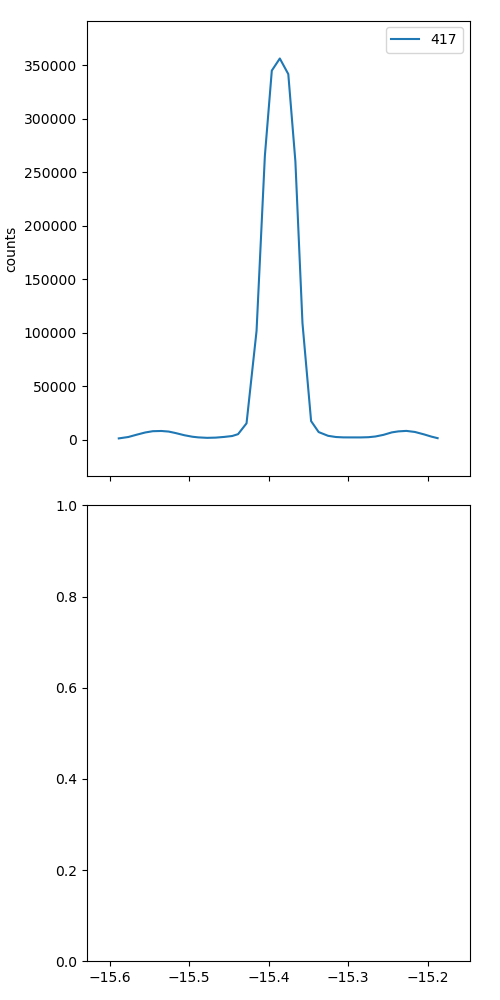

/opt/conda/lib/python3.7/site-packages/bluesky/callbacks/best_effort.py:274: UserWarning: Omitting SAXSDetector_full_file_name from plot because dtype is string
  "".format(y_key, dtype))


Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.32, 199.88, 238, 0.05, 0.2]
Finished Setting up for Acquisition
-15.385900352874527


In [73]:
gi.slit_scan_centre(-0.2, 0.2, 41)


In [7]:
(1586-1466) * .172

20.639999999999997

In [31]:
RE.abort()

TransitionError: RunEngine is already idle.

In [ ]:
gi.sample_z_displacement_deadband = 1000

In [ ]:
gi.control_sample_z_displacement

In [ ]:
gi.blade_x.limits
desired_x_pos

In [ ]:
gi.blade_y.limits


In [ ]:
ylim_low, ylim_high = gi.blade_y.limits
ylim_high > 12 > ylim_low

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [199.96, 200.73, 213, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
image intensity of 29.0 is outside the range of (40, 250)
(40, 250, 29.0)
Positioning done by set_feedback function
Full_beam_counts: 325966
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from -2.192 to,  0.808
beam_counts = 325966
fractional_intensity_target = 0.5
i =  0 height =  -0.692 counts =  326886
i =  1 height =  0.058 counts =  0
i =  2 height =  -0.317 counts =  325346
i =  3 height =  -0.1295 counts =  0
i =  4 height =  -0.223 counts =  7
i =  5 height =  -0.27 counts =  310669
i =  6 height =  -0.2465 counts =  10363
i =  7 height =  -0.258 counts =  171493
i =  8 height =  -0.252 counts =  51838
i =  9 height =  -0.255 counts =  111360
i =  10 height =  -0.2565 counts =  137775
final aligned position = -0.257 final aligned counts = 149603 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


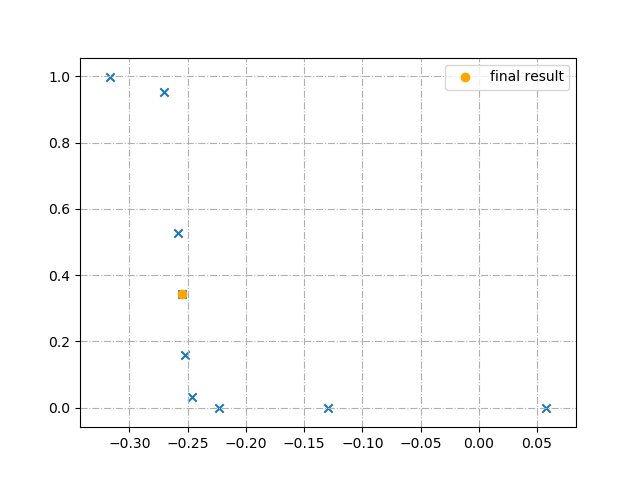

Counts: 147197, Target: 162983
Skipping coarse omega.
skip_fine_omega = True. Now break statement
Final Halvies Height Scan
Counts: 140755, Target: 162983
nk_final_counts 140755 nk_final_target 162983
Skipping new
Finished alignment successfully. Woot!
Setup for acquisition after align = False


(140755,
 162983,
 -0.25700000000000056,
 -1.1193122001207367e-05,
 True,
 True,
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 -0.08280000000000001)

In [81]:
# just do fast height alingment
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False, skip_coarse_omega = True, skip_fine_omega = True, reset_omega = False, 
                                          setup_for_acquisition_after_align = False)

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.02, 199.35, 213, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
image intensity of 18.0 is outside the range of (40, 250)
(40, 250, 18.0)
Positioning done by set_feedback function
Full_beam_counts: 343870
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 3.3 to,  6.3
beam_counts = 343870
fractional_intensity_target = 0.5
i =  0 height =  4.8 counts =  342558
i =  1 height =  5.55 counts =  5
i =  2 height =  5.175 counts =  8
i =  3 height =  4.9875 counts =  343375
i =  4 height =  5.0815 counts =  343372
i =  5 height =  5.1285 counts =  310193
i =  6 height =  5.1515 counts =  4043
i =  7 height =  5.14 counts =  96597
i =  8 height =  5.1345 counts =  222632
i =  9 height =  5.1375 counts =  149561
i =  10 height =  5.136 counts =  189259
final aligned position = 5.1365 final aligned counts = 175349 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


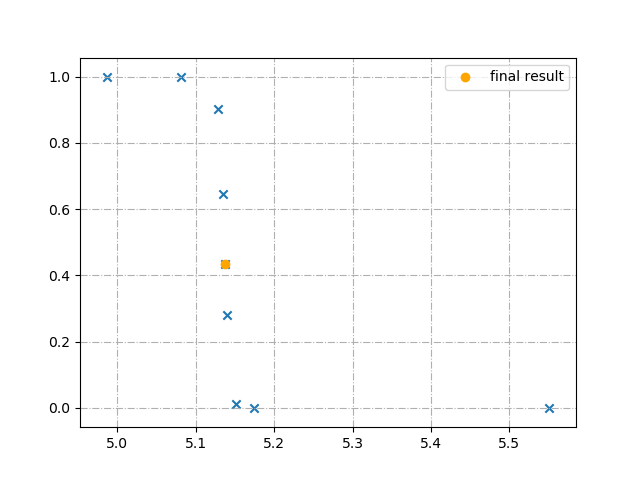

/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Counts: 173614, Target: 171935
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f71f8240828>


<IPython.core.display.Javascript object>


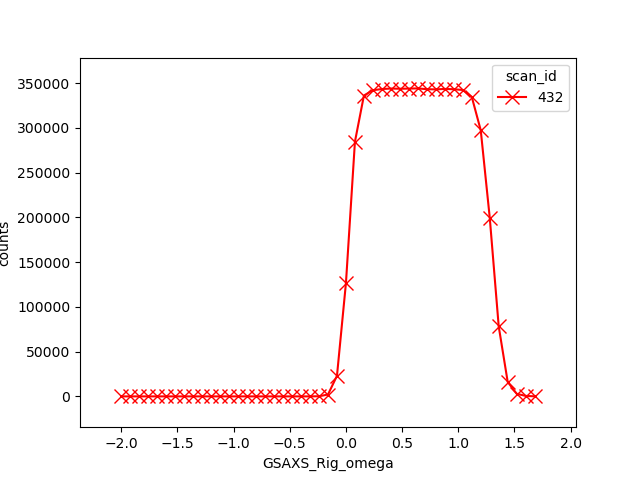

OmegaAnalysis: points at max = [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
OmegaAnalysis: starts: 0 lengths: 12
omega_scan2: omega_analysis.com = None
omega_scan2: omega_analysis.mid_plateau = 0.603005855261405 4
mid
moving to centre of omega scan at 0.603005855261405 degrees
Coarse scan peaked at 100.11 % of full flux.
moving sample up after coarse scan because >95%
height wrong (low), repeating scan
retries = 1
Positioning done by set_feedback function
Full_beam_counts: 355755
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 3.144 to,  6.144
beam_counts = 355755
fractional_intensity_target = 0.5
i =  0 height =  4.644 counts =  356245
i =  1 height =  5.394 counts =  3
i =  2 height =  5.019 counts =  356311
i =  3 height =  5.2065 counts =  1873
i =  4 height =  5.1125 counts =  356199
i =  5 height =  5.1595 counts =  356457
i =  6 height =  5.183 counts =  278404
i =  7 height =  5.1945 counts =  58427
i =  8 height =  5.1885 counts =  172628
i =  

<IPython.core.display.Javascript object>


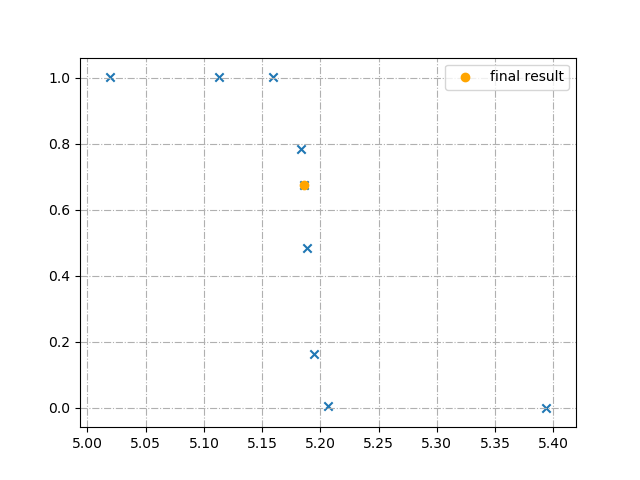

Counts: 190803, Target: 177877
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f71dd7f6550>


<IPython.core.display.Javascript object>


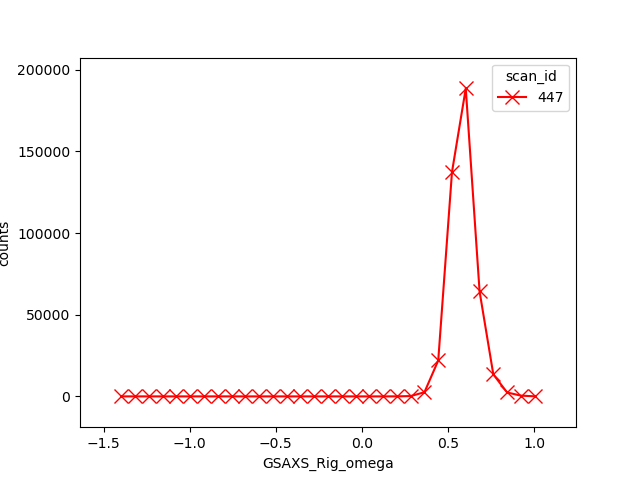

OmegaAnalysis: points at max = []
omega_scan2: omega_analysis.com = 0.6026921286846034
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at 0.6026921286846034 degrees
Coarse scan peaked at 53.01 % of full flux.
Running Fine Omega Scan
auto_fine_scan_range=  (0.39, 0.84, 41, 0.01125)


<IPython.core.display.Javascript object>


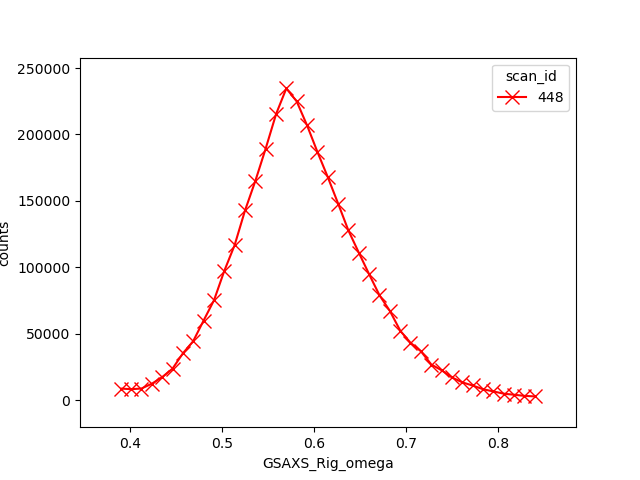

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = 0.5695599927838351
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 8.985 +/- 0.074
sample height displacement, mm = -0.003332 +/- 4.4e-05
sample height displacement, microns = -3.3318 +/- 0.044
sample z displacement, mm = -0.567 +/- -0.567
sample pitch offset, degree = 0.570701 +/- 0.000558
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


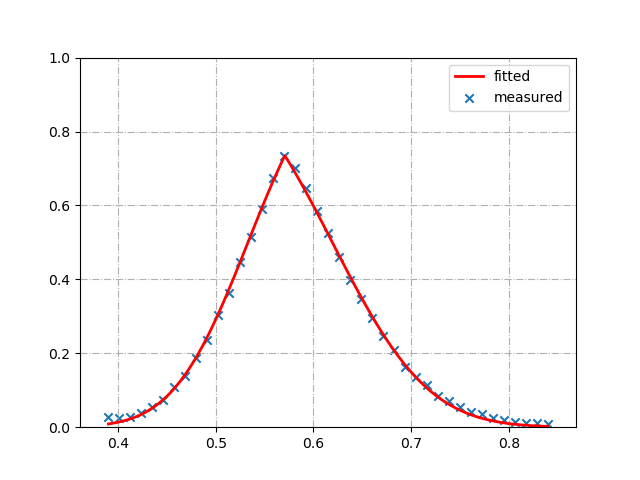

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at 5.1875
Moved sample height to fitted position of  5.191 

moving to centre of omega scan at 0.5707 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at 5.191
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from 5.1535 to,  5.2285
beam_counts = 355755
fractional_intensity_target = 0.5
i =  0 height =  5.191 counts =  168355
i =  1 height =  5.1535 counts =  356209
i =  2 height =  5.1725 counts =  353378
i =  3 height =  5.1815 counts =  325141
i =  4 height =  5.1865 counts =  263699
i =  5 height =  5.189 counts =  216309
i =  6 height =  5.19 counts =  196689
final aligned position = 5.1905 final aligned counts = 185694 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


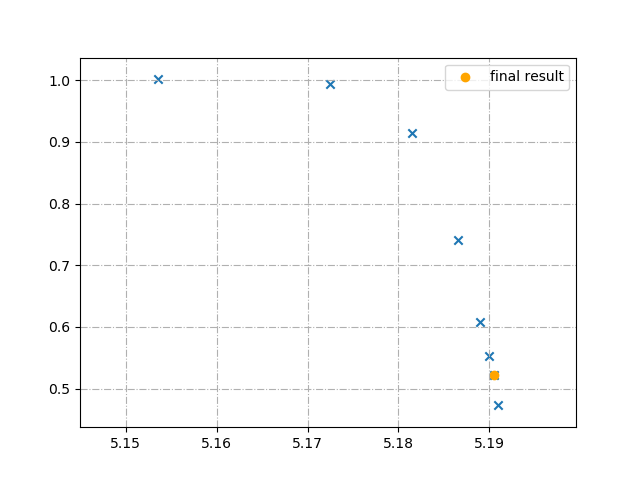

Counts: 184842, Target: 177877
Rezero Omega
nk_final_counts 184842 nk_final_target 177877
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.31, 199.8, 237, 0.05, 0.2]
Finished Setting up for Acquisition


(184842,
 177877,
 5.1905,
 0.5708406758609598,
 [-1.3968415281671027,
  -1.3170967419386057,
  -1.2373395691723188,
  -1.1573182029330478,
  -1.0771060312986278,
  -0.9974033838743337,
  -0.9173619133187847,
  -0.8373619133038839,
  -0.7570680563844037,
  -0.677292818817037,
  -0.5973972664018997,
  -0.5174284806165012,
  -0.4373078713153966,
  -0.35734506816281153,
  -0.27727827778047875,
  -0.19730787131539662,
  -0.11736191331878504,
  -0.03712655217451122,
  0.042660430827681256,
  0.12269363868460341,
  0.20291192883565398,
  0.28262655706489725,
  0.3627707753369682,
  0.4429076696955411,
  0.5226658574554937,
  0.6026921286846034,
  0.6829032580613944,
  0.7626147674478357,
  0.8427311389334076,
  0.9229219293206556,
  1.002697199153158],
 [11.0,
  8.0,
  12.0,
  1.0,
  3.0,
  5.0,
  8.0,
  9.0,
  10.0,
  5.0,
  3.0,
  6.0,
  3.0,
  3.0,
  5.0,
  4.0,
  1.0,
  4.0,
  3.0,
  4.0,
  28.0,
  207.0,
  2540.0,
  21999.0,
  137353.0,
  188591.0,
  64246.0,
  13479.0,
  2415.0,
  462.

In [74]:
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)

In [ ]:
#     def scan_that_thang(self, scan_filename, setup=True, use_shutter = False, user_gapless = True, user_shutter = False, exposure_time = 1.0):
#         self.table3(filename=scan_filename,
#                image_path=None,
#                exp_time=exposure_time,
#                num_images = 1,
#                motor1 = self.pitch_motor,
#                points1 = self.acquire_angles,
#                motor2 = self.x_motor,
#                points2 = [self.x_motor.position + i for i in self.X_position_relative_list],    # this makes it absolute from relative input
#                motor3 = beamstop.y,
#                points3 = self.beamstop_positions,
#                filename_device = saxs_detector.file_name,
#               #filenames = [scan_filename for a in acquire_angles])
#                filenames = [f'{scan_filename}_{a}'.replace('.', 'p') for a in self.acquire_angles],
#                gapless = user_gapless,
#                #gapless = True,
#                use_feedback = 1,
#                #use_shutter = False,
#                use_shutter = user_shutter
#               )

In [ ]:
gi.acquire_angles=[0.1,0.2]
gi.scan_that_thang('my_file_name')

In [ ]:
gi.acquire_angles

In [112]:
#################################################### RUN THIS CELL FIRST  ################
# things to set during routine acquisition, and display spreadsheet (without running it)
#gi.align_fdbk_nominal_exptime = 0.05
#gi.align_fdbk_nominal_gain = 5
#
# -------------------- LOAD THIS FIRST FOR SPREADSHEET ------------------------------------------
#
gi.spreadsheet_key = '18dW6IP9_lp7cT29iuHfI9yyClVmWqxfLwWs8Vmp2MM4'

gi.wks_name = 'sheet_4'

gi.max_sample_thickness = 2   #### DON'T FORGET TO CORRECT SAMPLE THICKNESS


gi.align_coarse_omega_range = [-1,1]
gi.align_coarse_omega_points = 41

# display the spreadsheet (but don't run it)

gi.per_sample_repeats = 0   #Repeats on top of initial angle scan
gi.loop_wait_time = 60      #waiting time in seconds between angle scan repeats
gi.loop_x_offset  = 0    #wposition offset of loop from original starting x-position (mm)

#gi.beamstop_height = 9

gi.load_process_spreadsheet()

,Sample_name,Skip_sample,Sample_length,Sample_holder,X_position,Skip_alignment,Skip_coarse_omega,Skip_fine_omega,hxp_offset,Exposure_time,angles,X_position_grid_list,Repeat_angle_list,x_per_shot_offset,Second_camera_length,User_label,(User notes - Final X)
0,X9_01,0,14.0,1,-54.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
1,X9_02,0,14.0,1,-42.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
2,Q9_01,0,12.0,1,-25.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
3,X3_01,0,12.0,1,-12.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
4,X3_02,0,10.0,1,-1.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
5,X3_04,0,10.0,1,10.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
6,X3_05,0,11.0,1,21.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,
7,X8_02r,0,14.0,1,35.0,0,0,0,-0.25,1.0,"[0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, ...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",1,0.25,0,,


Shooting sample 8 of 8 , X8_02r at the x position:, 35.0 at height 3.33 and hxp offset 3.33
skip_alignment = 0
skip_coarse_omega = 0
skip_fine_omega = 0
Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.09, 199.03, 214, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
image intensity of 33.0 is outside the range of (40, 250)
(40, 250, 33.0)
Positioning done by set_feedback function
Full_beam_counts: 382583
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 0.33 to,  4.33
beam_counts = 382583
fractional_intensity_target = 0.5
i =  0 height =  2.33 counts =  381928
i =  1 height =  3.33 counts =  1
i =  2 height =  2.83 counts =  382352
i =  3 height =  3.08 counts =  382445
i =  4 height =  3.205 counts =  13657
i =  5 height =  3.1425 counts =  383378
i =  6 height =  3.1735 counts =  381121
i =  7 height =  3.1895 counts =  273856
i =  8 height =  3.1975 counts =  81593
i =  9 height =  3.1935 counts

<IPython.core.display.Javascript object>


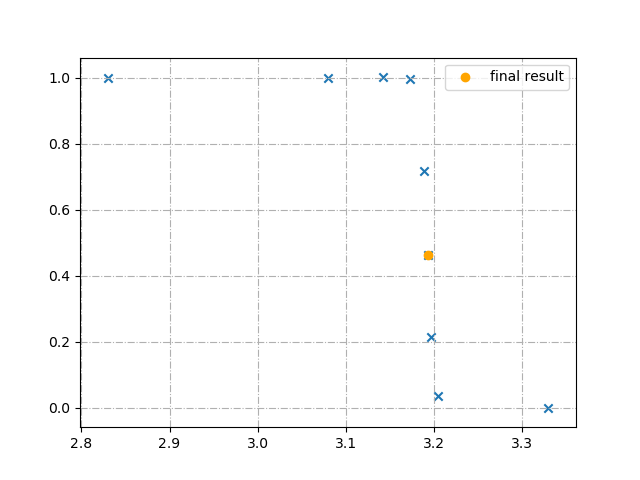

Counts: 198294, Target: 191291
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f3809844be0>


<IPython.core.display.Javascript object>


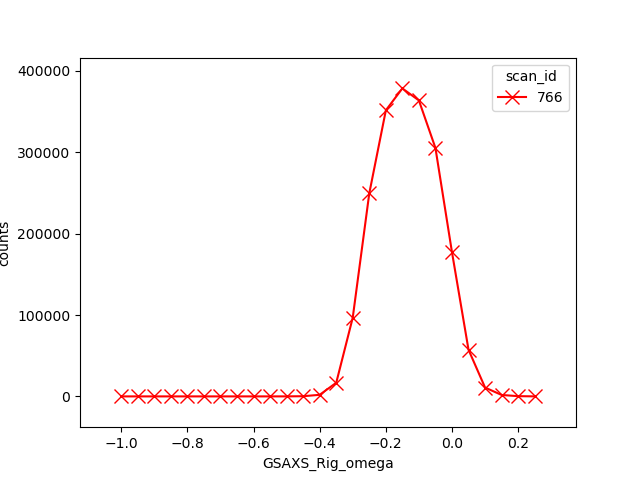

OmegaAnalysis: points at max = [16 17 18]
omega_scan2: omega_analysis.com = -0.15015367931412674
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at -0.15015367931412674 degrees
Coarse scan peaked at 98.96 % of full flux.
moving sample up after coarse scan because >95%
Running Fine Omega Scan
auto_fine_scan_range=  (-0.35, 0.12, 41, 0.01175)


<IPython.core.display.Javascript object>


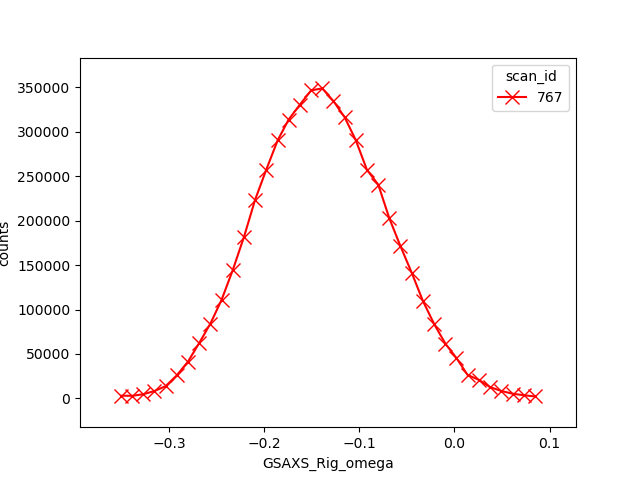

Trying to run stop method
OmegaAnalysis: points at max = [17 18]
fitting Gauss slicing parameters
angle at highest intensity = -0.13891705663330053
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 13.612 +/- 0.258
sample height displacement, mm = -0.010119 +/- 0.000203
sample height displacement, microns = -10.1192 +/- 0.2033
sample z displacement, mm = -0.448 +/- -0.448
sample pitch offset, degree = -0.146521 +/- 0.001714
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


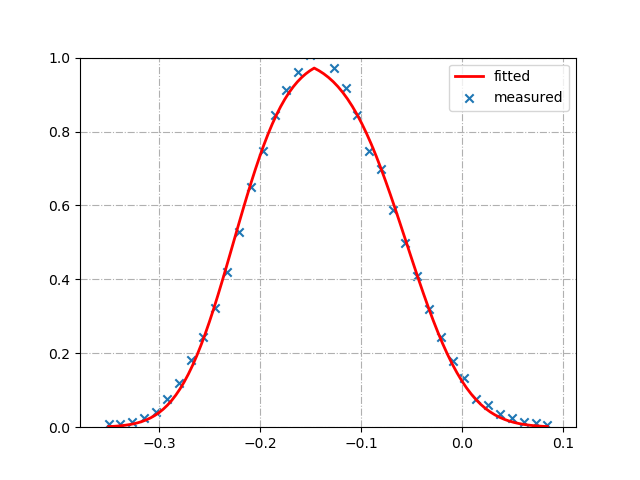

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at 3.2
Moved sample height to fitted position of  3.21 

moving to centre of omega scan at -0.1465 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at 3.21
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from 3.1725 to,  3.2475
beam_counts = 382583
fractional_intensity_target = 0.5
i =  0 height =  3.21 counts =  189382
i =  1 height =  3.1725 counts =  383184
i =  2 height =  3.1915 counts =  380743
i =  3 height =  3.2005 counts =  335241
i =  4 height =  3.2055 counts =  278440
i =  5 height =  3.2075 counts =  227763
i =  6 height =  3.209 counts =  198302
final aligned position = 3.2095 final aligned counts = 187084 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


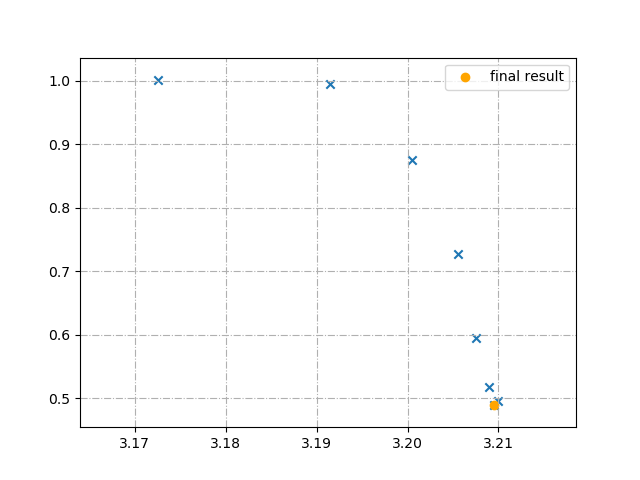

Counts: 185930, Target: 191291
Rezero Omega
nk_final_counts 185930 nk_final_target 191291
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Feedback camera tuning successful.
Final feedback results for setup_for_acquire were [200.3, 199.64, 190, 0.0118, 0.2]
Finished Setting up for Acquisition
Acquiring Scattering Data
Final alignment counts =  185930 Target alignment counts =  191291
Done everything as you requested, if not, I tried


In [113]:
###################################### RUN THIS CEL AFTERWARDS  #########################################
# RUN ALL THE RELEVANT SAMPLES IN THE SPREADSHEET
# use "Abort batch" toggle on "Top Level Experiment Screen" GUI to stop a batch - it will finish the current sample and then exit the batch nicely.

# HAVE YOU MOVED THE BLADE AWAY FOR SPREADSHEET RUN???

gi.blade_y.set(22, wait=True)
gi.reset_batch_controls()
gi.run_samples_from_spreadsheet()

# run samples

In [ ]:
###################################### RUN THIS CEL AFTERWARDS  #########################################
# RUN ALL THE RELEVANT SAMPLES IN THE SPREADSHEET
# use "Abort batch" toggle on "Top Level Experiment Screen" GUI to stop a batch - it will finish the current sample and then exit the batch nicely.
gi.reset_batch_controls()
gi.run_samples_from_spreadsheet()

# run samples

In [71]:
#############################################################################################################
### 00 STOP COMMANDS!
#############################################################################################################
sa.abort()
RE.abort()


TransitionError: RunEngine is already idle.

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [199.95, 199.04, 214, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
image intensity of 21.0 is outside the range of (40, 250)
(40, 250, 21.0)
Positioning done by set_feedback function


Transient Scan ID: 1     Time: 2025-07-24 14:26:57
Persistent Unique Scan ID: '65b442cd-9d5e-4093-ac24-ca774656cf30'
New stream: 'primary'
+-----------+------------+-----------------------------+------------+
|   seq_num |       time | SAXSDetector_full_file_name |     counts |
+-----------+------------+-----------------------------+------------+
|         1 | 14:26:58.2 |                         /da |     374447 |
+-----------+------------+-----------------------------+------------+
generator count ['65b442cd'] (scan num: 1)



Full_beam_counts: 374447
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 1.312 to,  5.312
beam_counts = 374447
fractional_intensity_target = 0

<IPython.core.display.Javascript object>


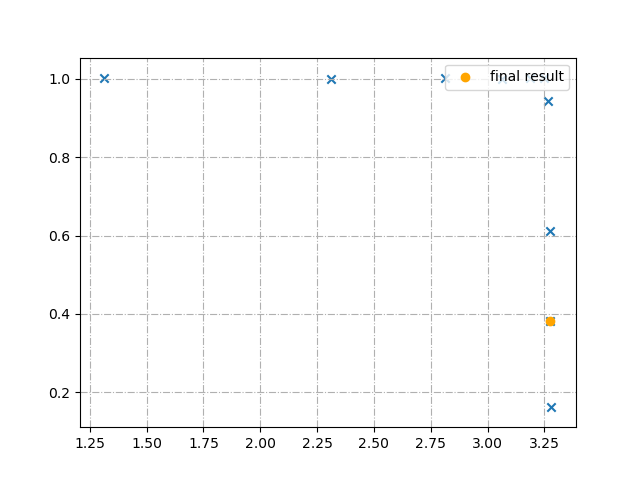

/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Counts: 173620, Target: 187223
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f705a62a438>


<IPython.core.display.Javascript object>


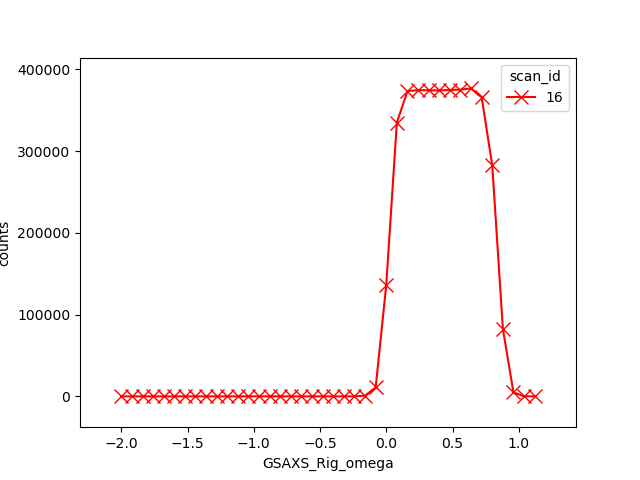

OmegaAnalysis: points at max = [26 27 28 29 30 31 32 33 34]
OmegaAnalysis: starts: 0 lengths: 6
omega_scan2: omega_analysis.com = None
omega_scan2: omega_analysis.mid_plateau = 0.3663306213089564 4
mid
moving to centre of omega scan at 0.3663306213089564 degrees
Coarse scan peaked at 100.62 % of full flux.
moving sample up after coarse scan because >95%
height wrong (low), repeating scan
retries = 1
image intensity of 20.0 is outside the range of (40, 250)
(40, 250, 20.0)
Positioning done by set_feedback function
Full_beam_counts: 369517
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 0.282 to,  4.282
beam_counts = 369517
fractional_intensity_target = 0.5
i =  0 height =  2.282 counts =  368150
i =  1 height =  3.282 counts =  369215
i =  2 height =  4.282 counts =  0
i =  3 height =  3.782 counts =  8
i =  4 height =  3.532 counts =  2
i =  5 height =  3.407 counts =  10
i =  6 height =  3.3445 counts =  529
i =  7 height =  3.3135 counts =  337961
i =  

<IPython.core.display.Javascript object>


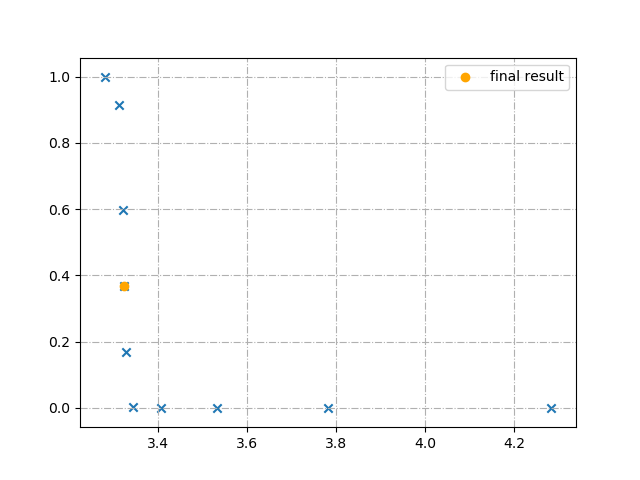

Counts: 190838, Target: 184758
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f70584610f0>


<IPython.core.display.Javascript object>


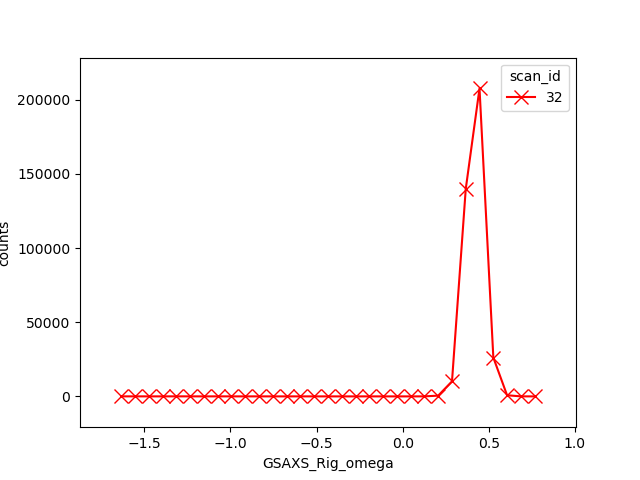

OmegaAnalysis: points at max = []
omega_scan2: omega_analysis.com = 0.4460005241967935
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at 0.4460005241967935 degrees
Coarse scan peaked at 56.22 % of full flux.
Running Fine Omega Scan
auto_fine_scan_range=  (0.32, 0.6, 41, 0.006999999999999999)


<IPython.core.display.Javascript object>


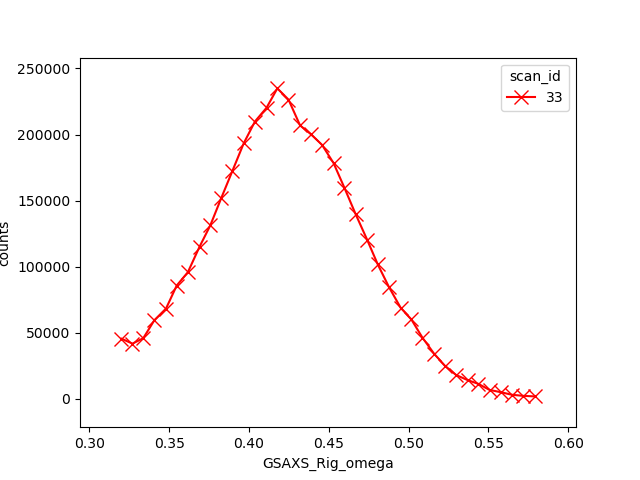

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = 0.41777205083575236
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 11.712 +/- 0.21
sample height displacement, mm = -0.003347 +/- 9.4e-05
sample height displacement, microns = -3.3465 +/- 0.0935
sample z displacement, mm = 0.008 +/- 0.008
sample pitch offset, degree = 0.42111 +/- 0.000915
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


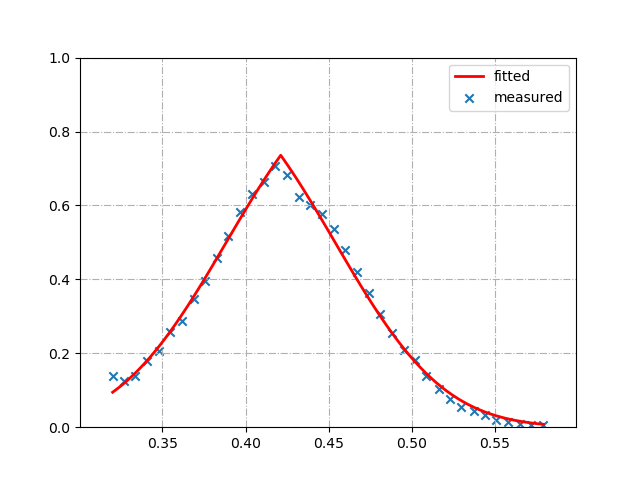

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at 3.322
Moved sample height to fitted position of  3.3255 

moving to centre of omega scan at 0.4211 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at 3.3255
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from 3.288 to,  3.363
beam_counts = 369517
fractional_intensity_target = 0.5
i =  0 height =  3.3255 counts =  183396
i =  1 height =  3.288 counts =  368681
i =  2 height =  3.3065 counts =  366421
i =  3 height =  3.316 counts =  331149
i =  4 height =  3.321 counts =  259006
i =  5 height =  3.3235 counts =  207939
i =  6 height =  3.3245 counts =  190458
final aligned position = 3.325 final aligned counts = 178834 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


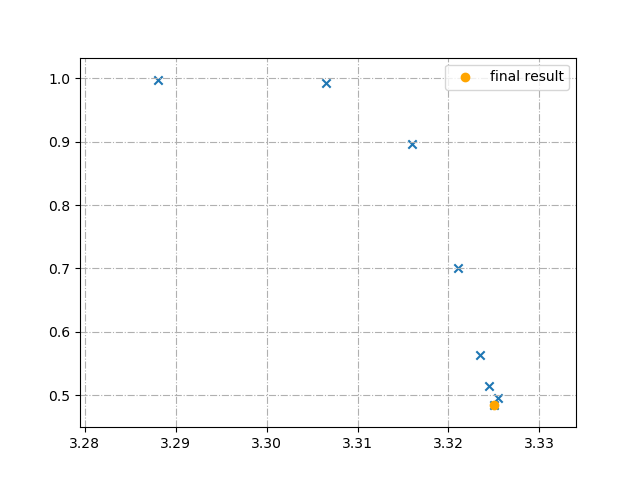

Counts: 177981, Target: 184758
Rezero Omega
nk_final_counts 177981 nk_final_target 184758
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.75, 199.88, 241, 0.05, 0.2]
Finished Setting up for Acquisition


In [11]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AT THE BEAM POSITION
#############################################################################################################

def rule_the_world():
    
    #get staring stuff
    starting_blade_x_velocity = gi.blade_x.velocity.get()
    starting_blade_y_velocity = gi.blade_y.velocity.get()
    starting_blade_x_position = gi.blade_x.position
    starting_blade_y_position = gi.blade_y.position
    
    # Choose the rules of the world
    desired_y_vel = 2 #mm/s
    desired_x_vel = 5 #mm/s
    desired_y_pos = starting_blade_y_position + 10
    desired_x_pos = starting_blade_x_position + 70
    
    # Check limits
    ylim_low, ylim_high = gi.blade_y.limits
    assert (ylim_low < desired_y_pos) and (desired_y_pos < ylim_high), "High limit for Y!"
    xlim_low, xlim_high = gi.blade_x.limits
    assert (xlim_low < desired_x_pos) and (desired_x_pos < xlim_high), "High limit for X!"

    # Set the velocities to move
    gi.blade_x.velocity.put(desired_x_vel)
    gi.blade_y.velocity.put(desired_y_vel)
    
    # Move
    gi.blade_y.set(desired_y_pos, wait=True)
    gi.blade_x.set(desired_x_pos, wait=True)
    
#     e = None
#     try:
    # Run the alingment
    gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
    
#     except Exception as e:
#         pass
    
    # Return the blade at a slow velocity
#     gi.blade_y.velocity.put(2)
    gi.blade_x.set(starting_blade_x_position, wait=True)
    gi.blade_y.set(starting_blade_y_position, wait=True)
    
    # Return the velocities
    gi.blade_x.velocity.put(starting_blade_x_velocity)
    gi.blade_y.velocity.put(starting_blade_y_velocity)
    
#     if e:
#         raise e
    
rule_the_world()

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [199.87, 199.44, 213, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 360836
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 0.413 to,  3.413
beam_counts = 360836
fractional_intensity_target = 0.5
i =  0 height =  1.913 counts =  359922
i =  1 height =  2.663 counts =  0
i =  2 height =  2.288 counts =  360104
i =  3 height =  2.4755 counts =  3
i =  4 height =  2.3815 counts =  359550
i =  5 height =  2.4285 counts =  80572
i =  6 height =  2.405 counts =  359897
i =  7 height =  2.417 counts =  299035
i =  8 height =  2.4225 counts =  194655
i =  9 height =  2.4255 counts =  142698
i =  10 height =  2.424 counts =  170898
final aligned position = 2.4235 final aligned counts = 179223 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


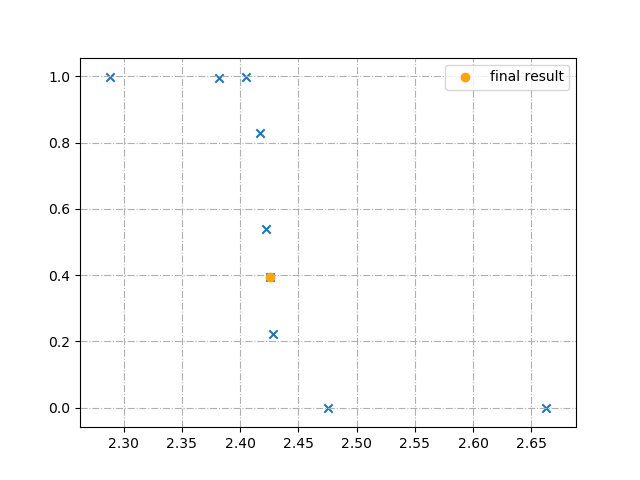

Counts: 177928, Target: 180418
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f139972c780>


<IPython.core.display.Javascript object>


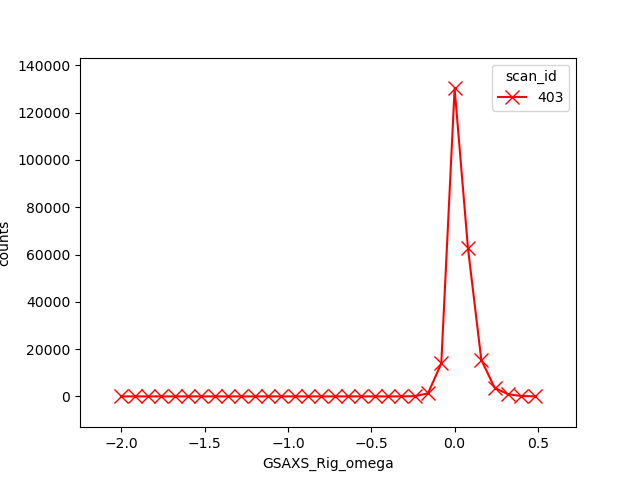

OmegaAnalysis: points at max = []
omega_scan2: omega_analysis.com = 3.5361796436048434e-05
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at 3.5361796436048434e-05 degrees
Coarse scan peaked at 36.1 % of full flux.
Running Fine Omega Scan
auto_fine_scan_range=  (-0.13, 0.24, 41, 0.00925)


<IPython.core.display.Javascript object>


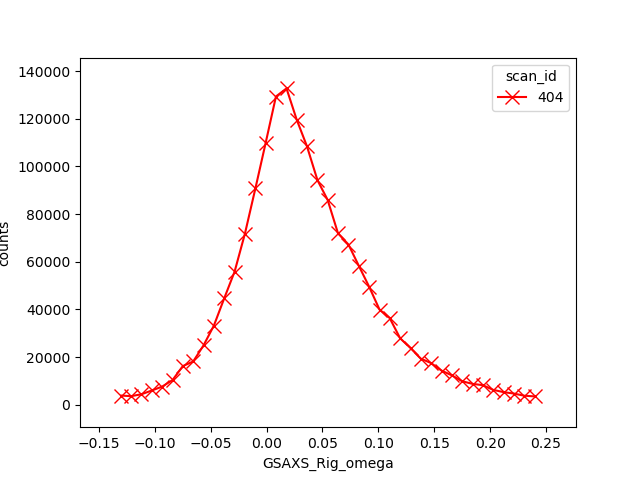

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = 0.017859063730156638
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 8.624 +/- 0.096
sample height displacement, mm = 0.000999 +/- 3.4e-05
sample height displacement, microns = 0.9991 +/- 0.0337
sample z displacement, mm = -1.077 +/- -1.077
sample pitch offset, degree = 0.012709 +/- 0.000461
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


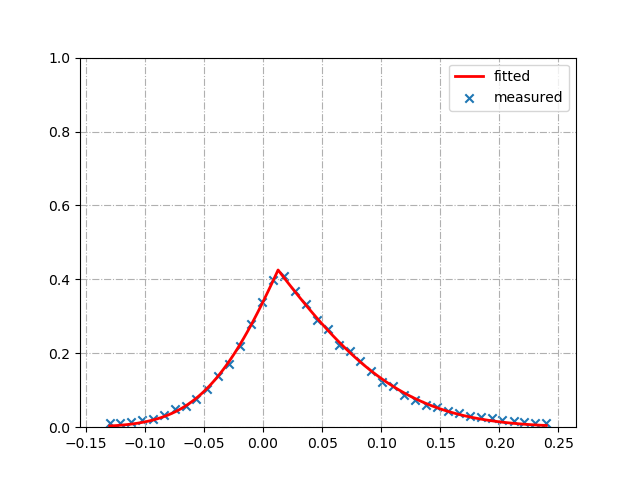

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at 2.4235
Moved sample height to fitted position of  2.4225 

moving to centre of omega scan at 0.0127 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at 2.4225
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from 2.385 to,  2.46
beam_counts = 360836
fractional_intensity_target = 0.5
i =  0 height =  2.4225 counts =  142953
i =  1 height =  2.385 counts =  357315
i =  2 height =  2.4035 counts =  356458
i =  3 height =  2.413 counts =  321551
i =  4 height =  2.4175 counts =  256639
i =  5 height =  2.42 counts =  205712
i =  6 height =  2.421 counts =  177910
final aligned position = 2.4205 final aligned counts = 192216 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


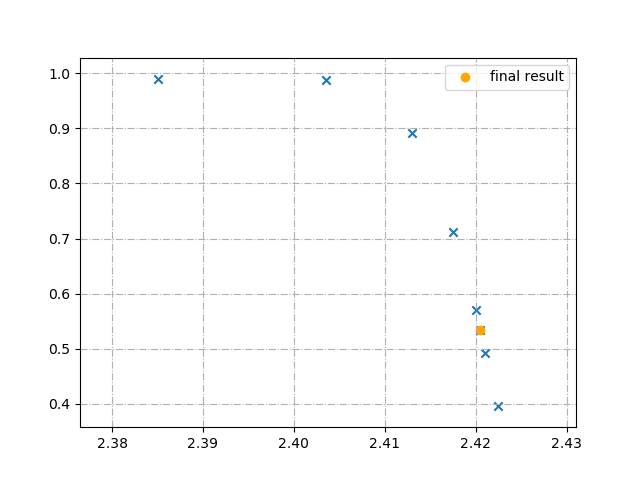

Counts: 195804, Target: 180418
Rezero Omega
nk_final_counts 195804 nk_final_target 180418
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.4, 199.83, 238, 0.05, 0.2]
Finished Setting up for Acquisition
YAY DONE!


In [121]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

In [16]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='test_angles'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [13]:
def move_blade_and_sample(offset, speed=0.4):
    # Positive offset is towards the user cabin, negative offset away.
    if speed >= 2:
        raise ValueError(f"{speed} mm/s too fast. limit 2.")
    else:
        # Collect initial velocities
        ini_bl_vx = gi.blade_x.velocity.get()
        ini_sm_vx = gsaxs.x.velocity.get()
        
        # Set new velocities
        gi.blade_x.velocity.put(speed)
        gsaxs.x.velocity.put(speed)

        # CHOSE SIGN CAREFULLY.
        gi.blade_x.set(gi.blade_x.position + offset, wait=False)
        gsaxs.x.set(gsaxs.x.position + offset, wait=False)
        
        # Return velocities.
        gi.blade_x.velocity.put(ini_bl_vx)
        gsaxs.x.velocity.put(ini_sm_vx)
        

In [ ]:
#############################################################################################################
### Move the blade and sample at the same same time with the same speed - to adjust the initial position!
#############################################################################################################

# Test it here
move_blade_and_sample(5,1)

In [15]:
#############################################################################################################
### Create the single shot fast function! and import required libraries.
#############################################################################################################
import pandas as pd
import time
import os
def fast_GI_scan_single_shot(filename, exposure_time):
    # Still takes about 2s overhead due to shutter opening closing if you keep shooting single shots.
        per_shot = sps.per_step_with_shutter_video_count
        inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
        plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(filename),
                       exp_time=exposure_time,
                       num_images_per_trigger=1,
                       use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
                       open_shutter=True)

        sa.queue({"type": "plan", "data": plan}, wait=True)
        
def fast_GI_scan_multi_shot(filename, exposure_time, number_shots):
        per_shot = sps.per_step_with_shutter_video_count
        inner_plan = count(detectors, num=1, delay=0, per_shot=per_shot)
        plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(filename),
                       exp_time=exposure_time,
                       num_images_per_trigger=number_shots,
                       use_feedback=False,     # note: True requires FE and Monoshuter open, False does not require FE shuter open
                       open_shutter=False)

        sa.queue({"type": "plan", "data": plan}, wait=False)
        
# file_number = PV('SR13ID01PIL1:cam1:FileNumber_RBV') # Indicates the next filenumber to save (not previous!)
# frame_number = PV('SR13ID01PIL1:cam1:ArrayCounter_RBV') # Indicates the current frame measured by the detector --> 0 is running, 1 is 1st done and 2nd running etc. 

In [7]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [152]:
#############################################################################################################
# Run a blade!!!!! - without Gating
# -> Make sure you have the initial position on the water meniscus attached to the blade, near the right edge of the sample.
# -> This program will `dry_offset` to a position to measure the dry film, before introducing water for 5 minutes, before running the acquisition scan.
# -> You should know the critical angle already.
# -> You should have the sample aligned already.
#############################################################################################################
sample_name = "Q5_01_r01"
angle_of_incidence = 0.095
mensicus_width = 3 # what is the space I can measure accross -> determines measurement total time.
dry_offset = -8 #mm #must be negative to move beam spot to the left of the water.
time_soak = 60*5 #seconds 60*5
stage_speed = 0.1 #mm/s (maximum is 2)
blade_speed = 0.45 #mm/s
sample_movement = - mensicus_width #mm, relative to initial position.
blade_movement = 7 #mm, relative to initial position.
measurement_time = 0.1 # time per shot.

# Limits
assert stage_speed < 2, "Maximum is 2"
assert sample_movement <= 0, "Sample stage movement in the -ve direction is negative."
time_delta1 = abs(sample_movement)/abs(stage_speed)
time_delta2 = abs(blade_movement)/abs(blade_speed)
time_detla = time_delta1 if time_delta1 > time_delta2 else time_delta2
# Calculate number of shots and start shooting
num_shots = int((time_detla) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)

# First move the sample to a dry spot `dry_offset` mm away.
assert dry_offset < 0
# move to dry spot!!
move_blade_and_sample(dry_offset, 0.4)
time.sleep(abs(dry_offset) / 0.4) # Wait for movement to finish.

# Code to do the initial measurement that is gapless
f_num = file_number.get()
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
fname = sample_name_format_pre.format(sample_name = sample_name, f_num = f_num)
# Run the scan
gi.scan_that_thang(scan_filename=sample_name + "_pre", setup=False, exposure_time=1.0)

# Save the information
if safety_measurement:
    data = {
        "timestamp (s)" : [-time_soak],
        "scan#" : [f_num],
        "filename" : [fname],
        "blade_x (mm)" : [gi.blade_x.position],
        "sample_x (mm)" : [gsaxs.x.position],
    }
else:
    raise ValueError("Not safe to run a measurement. Have you saved data?")

# Move the blade so the water sits on the current position for 5 minutes.
gi.blade_x.velocity.put(blade_speed)
print("Moving to wet position")
gi.blade_x.set(gi.blade_x.position - dry_offset, wait=True)
print(f"Move complete, waiting for {time_soak - 5 if time_soak > 5 else 0}s")
time.sleep(time_soak - 5 if time_soak > 5 else 0)
print("Soak complete. Running measurement in 5s.")
time.sleep(5)

# Run an initial scan
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)

# Start shooting
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

# Start the movement of the motors after initializing the camera.
## Blade
final_blade_x = init_blade_x + blade_movement
gi.blade_x.set(final_blade_x, wait=False)
## Stage
final_sample_x = init_sample_x + sample_movement
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get()
for i in range(num_shots):
    while f2_num != i:
        f2_num = frame_number.get()
        time.sleep(0.001)
        
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
    
# Wait for some time after measurement... fully dry?
time.sleep(30)

# TAKE ONE LAST IMAGE another 10s later for clarity on what's been measured.
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
f_num = file_number.get()

fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
gi.scan_that_thang(scan_filename=sample_name + "_post", setup=False, exposure_time=1.0)
f2_num = frame_number.get()
data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["blade_x (mm)"].append(gi.blade_x.position)
data["sample_x (mm)"].append(gsaxs.x.position)

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed (mm/s)": stage_speed,
            "blade_speed (mm/s)": blade_speed,
            "sample_movement (mm)": sample_movement,
            "blade_movement" : blade_movement,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "soak_time (s)" : time_soak,
            "dry_offset (mm)" : dry_offset,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
    
df


Number of shots 300
Moving to wet position
Move complete, waiting for 295s
Soak complete. Running measurement in 5s.


,timestamp (s),scan#,filename,blade_x (mm),sample_x (mm)
0,-300,1419,Q2_05_r01_pre_1419.tif,48.99885123830773,2.581866221213077
1,1.688474178314209,1420,Q2_05_r01_1420_0001.tif,57.58001410939057,2.453872042540172
2,2.777101516723633,1420,Q2_05_r01_1420_0002.tif,58.07658069499094,2.343523913267711
3,2.874842405319214,1420,Q2_05_r01_1420_0003.tif,58.12922980286438,2.3317741124515328
4,2.9811911582946777,1420,Q2_05_r01_1420_0004.tif,58.17895396031697,2.320774298924664
5,3.0783329010009766,1420,Q2_05_r01_1420_0005.tif,58.22867811776955,2.309724486265043
6,3.186455726623535,1420,Q2_05_r01_1420_0006.tif,58.27795228280385,2.298774671870926
7,3.3031013011932373,1420,Q2_05_r01_1420_0007.tif,58.32745144404728,2.287774858344058
8,3.400747299194336,1420,Q2_05_r01_1420_0008.tif,58.37695060529072,2.276775044817189
9,3.5077223777770996,1420,Q2_05_r01_1420_0009.tif,58.42622477032501,2.265775231364826


ERROR:ophyd.objects:Motion failed: Sample_Table_x is in an alarm state status=AlarmStatus.LOW severity=AlarmSeverity.MAJOR


In [29]:
# Manually Save the data to file
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed (mm/s)": stage_speed,
            "blade_speed (mm/s)": blade_speed,
            "sample_movement (mm)": sample_movement,
            "blade_movement" : blade_movement,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "soak_time (s)" : time_soak,
            "dry_offset (mm)" : dry_offset,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
# Save the data frame

csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
df

FILE `/home/jovyan/work/McNeill_23899_InSitu/Q1_01_r01_settings.txt` ALREADY EXISTS
FILE `/home/jovyan/work/McNeill_23899_InSitu/Q1_01_r01.csv` ALREADY EXISTS
FILE `/home/jovyan/work/McNeill_23899_InSitu/Q1_01_r01.txt` ALREADY EXISTS


,timestamp (s),scan#,filename,blade_x (mm),sample_x (mm)
0,0,987,Q1_01_r01_0987_0003.tif,48.996655845383046,0.7506694428815202
1,1.6906917095184326,988,Q1_01_r01_0988_0001.tif,49.577285761910275,0.562498373243693
2,2.688689708709717,988,Q1_01_r01_0988_0002.tif,50.02345320172866,0.4137758837674892
3,2.785748243331909,988,Q1_01_r01_0988_0003.tif,50.07295236297209,0.3972011635487114
4,2.8932840824127197,988,Q1_01_r01_0988_0004.tif,50.1229015163358,0.3806264433299331
5,2.9899978637695312,988,Q1_01_r01_0988_0005.tif,50.175325628000095,0.36315173827457725
6,3.097700595855713,988,Q1_01_r01_0988_0006.tif,50.224824789243534,0.34657701813030606
7,3.203921318054199,988,Q1_01_r01_0988_0007.tif,50.27432395048697,0.33015229538429125
8,3.3108022212982178,988,Q1_01_r01_0988_0008.tif,50.3242731041487,0.31350257635462686
9,3.419112205505371,988,Q1_01_r01_0988_0009.tif,50.37399726160128,0.29692785621035434


In [49]:
#############################################################################################################
# Reset to the initial blade / sample positions! WARNING - MIGHT DESTROY YOUR SAMPLE WITH LIQUID MOVEMENT?
#############################################################################################################
gsaxs.x.set(init_sample_x, wait=False)
gi.blade_x.set(init_blade_x, wait=False)


MoveStatus(done=False, pos=spare_gsaxs_channels_x, elapsed=0.0, success=False, settle_time=0.0)

In [8]:
# Import the necessary libraries to run the Agilent SMU libraries.
import threading
import time
import matplotlib.pyplot as plt
from McNeill_23899_2025_InAir_GatingControl import AgilentB2902A

#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.26, 199.73, 215, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 358834
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 1.342 to,  4.342
beam_counts = 358834
fractional_intensity_target = 0.5
i =  0 height =  2.842 counts =  356921
i =  1 height =  3.592 counts =  3
i =  2 height =  3.217 counts =  357452
i =  3 height =  3.4045 counts =  0
i =  4 height =  3.3105 counts =  13
i =  5 height =  3.264 counts =  330282
i =  6 height =  3.2875 counts =  7530
i =  7 height =  3.2755 counts =  126089
i =  8 height =  3.27 counts =  244053
i =  9 height =  3.273 counts =  172613
i =  10 height =  3.2715 counts =  203635
final aligned position = 3.2725 final aligned counts = 179247 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


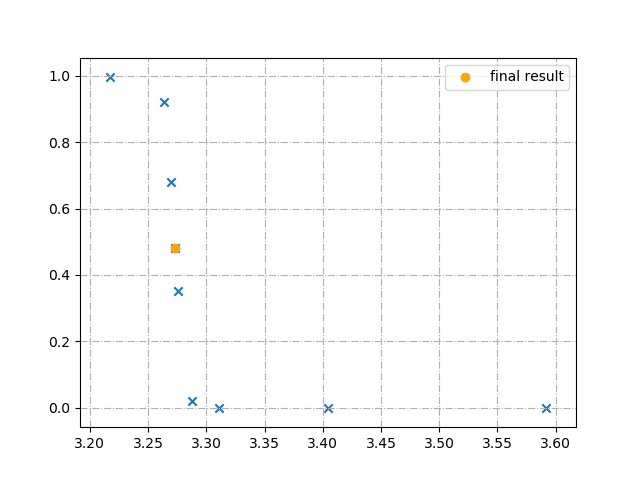

Counts: 178619, Target: 179417
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f71dc0c34e0>


<IPython.core.display.Javascript object>


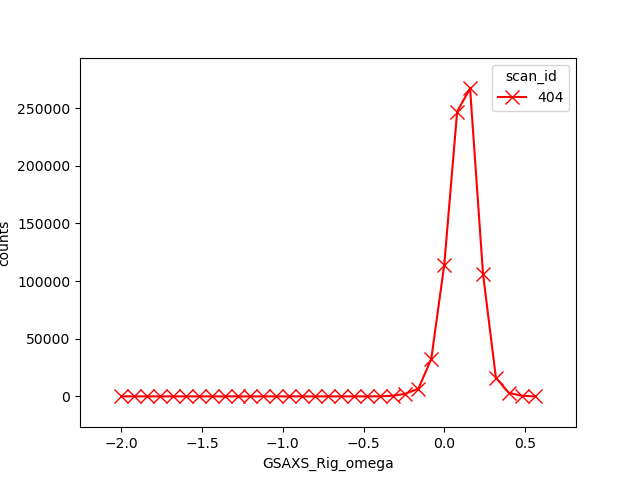

OmegaAnalysis: points at max = []
omega_scan2: omega_analysis.com = 0.1598569754529307
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at 0.1598569754529307 degrees
Coarse scan peaked at 74.41 % of full flux.
Running Fine Omega Scan
auto_fine_scan_range=  (-0.13, 0.39, 41, 0.013000000000000001)


<IPython.core.display.Javascript object>


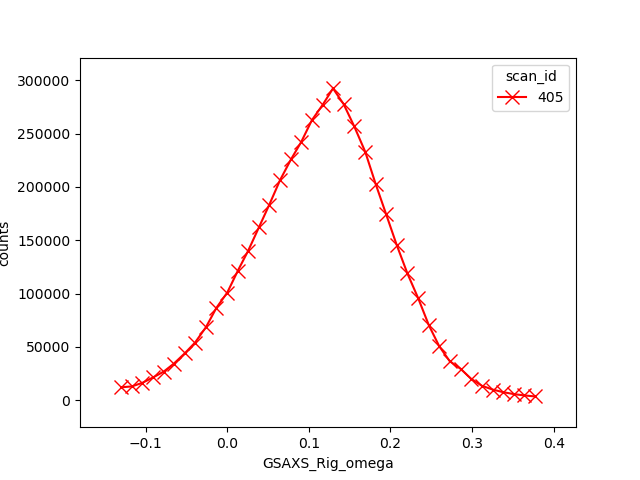

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = 0.12957062709602948
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 9.021 +/- 0.098
sample height displacement, mm = -0.006372 +/- 7.8e-05
sample height displacement, microns = -6.372 +/- 0.0777
sample z displacement, mm = 0.665 +/- 0.665
sample pitch offset, degree = 0.131445 +/- 0.001004
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


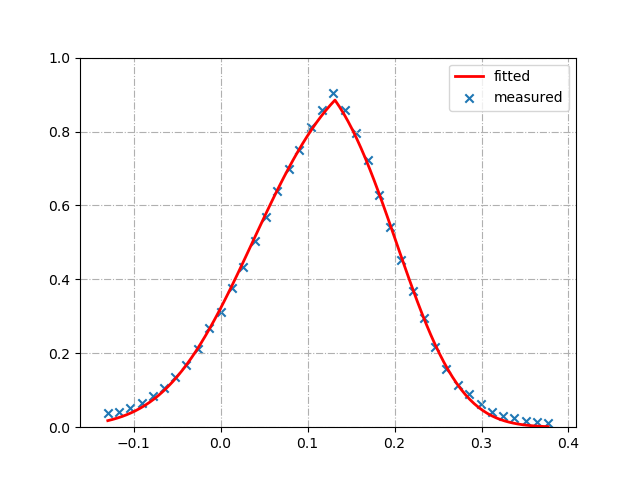

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at 3.2725
Moved sample height to fitted position of  3.279 

moving to centre of omega scan at 0.1314 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at 3.279
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from 3.2415 to,  3.3165
beam_counts = 358834
fractional_intensity_target = 0.5
i =  0 height =  3.279 counts =  158217
i =  1 height =  3.2415 counts =  356254
i =  2 height =  3.26 counts =  356917
i =  3 height =  3.2695 counts =  325649
i =  4 height =  3.2745 counts =  256647
i =  5 height =  3.2765 counts =  208446
i =  6 height =  3.2775 counts =  182138
i =  7 height =  3.2785 counts =  162016
i =  8 height =  3.278 counts =  171748
final aligned position =

<IPython.core.display.Javascript object>


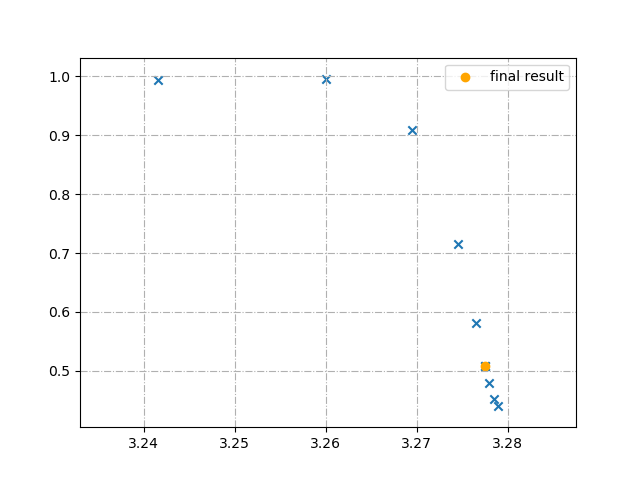

Counts: 178373, Target: 179417
Rezero Omega
nk_final_counts 178373 nk_final_target 179417
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.93, 200.4, 239, 0.05, 0.2]
Finished Setting up for Acquisition
YAY DONE!


In [67]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

In [68]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='M2_15_r01'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [69]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [70]:
#############################################################################################################
############################# # Run a blade!!!!! - WITH Gating BE CAREFULLLLLL############################## 

# IS THIS THE ONE???!?1/1/1/1/1/1/1
# -> Make sure you have the initial position on the water meniscus attached to the blade, near the right edge of the sample.
# -> This program will `dry_offset` to a position to measure the dry film, before introducing water for 5 minutes, before running the acquisition scan.
# -> You should know the critical angle already.
# -> You should have the sample aligned already.
#############################################################################################################
sample_name = "M2_15_r01"
angle_of_incidence = 0.105
voltage = 0 # Voltage is the blade, Sample is grounded
mensicus_width = 3 # what is the space I can measure accross -> determines measurement total time.
dry_offset = -7 #mm #must be negative to move beam spot to the left of the water. 1mm travel less
time_soak = 15 #seconds 60*5
stage_speed = 0.1 #mm/s (maximum is 2)
blade_speed = 0.45 #mm/s
sample_movement = - mensicus_width #mm, relative to initial position.
blade_movement = 5 #mm, relative to initial position. 2mm travel less
measurement_time = 0.1 # time per shot.


# Limits
assert stage_speed < 2, "Maximum is 2"
assert sample_movement <= 0, "Sample stage movement in the -ve direction is negative."
time_delta1 = abs(sample_movement)/abs(stage_speed)
time_delta2 = abs(blade_movement)/abs(blade_speed)
time_detla = time_delta1 if time_delta1 > time_delta2 else time_delta2
# Calculate number of shots and start shooting
num_shots = int((time_detla) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)
# Setup the gate
inst = AgilentB2902A()
inst.setup()


# First move the sample to a dry spot `dry_offset` mm away.
assert dry_offset < 0
# move to dry spot!!
move_blade_and_sample(dry_offset, 0.4)
time.sleep(abs(dry_offset) / 0.4) # Wait for movement to finish.

# Code to do the initial measurement that is gapless
f_num = file_number.get()
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
fname = sample_name_format_pre.format(sample_name = sample_name, f_num = f_num)
# Run the scan
gi.scan_that_thang(scan_filename=sample_name + "_pre", setup=False, exposure_time=1.0)

# Save the information
if safety_measurement:
    data = {
        "timestamp (s)" : [-time_soak],
        "scan#" : [f_num],
        "filename" : [fname],
        "blade_x (mm)" : [gi.blade_x.position],
        "sample_x (mm)" : [gsaxs.x.position],
    }
else:
    raise ValueError("Not safe to run a measurement. Have you saved data?")

# Move the blade so the water sits on the current position for 5 minutes.
gi.blade_x.velocity.put(blade_speed)
print("Moving to wet position")
gi.blade_x.set(gi.blade_x.position - dry_offset, wait=True)
print(f"Move complete, waiting for {time_soak - 5 if time_soak > 5 else 0}s")
# Setup the gating
new_thread = threading.Thread(target=inst.run_measurement, args=(
    #turn_on_time,  turn_on_voltage, turn_off_time_meas, turn_off_voltage=0, meas_interval=0.005
    1,              voltage,            1,                   0,                  0.050
))
new_thread.start()
time.sleep(1)
print("Turned on gate!")


time.sleep(time_soak - 5 if time_soak > 5 else 0)
print("Soak complete. Running measurement in 5s.")
time.sleep(5)

# Run an initial scan
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_speed)
## Stage speed
gsaxs.x.velocity.put(stage_speed)

# Start shooting
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

# Start the movement of the motors after initializing the camera.
## Blade
final_blade_x = init_blade_x + blade_movement
gi.blade_x.set(final_blade_x, wait=False)
## Stage
final_sample_x = init_sample_x + sample_movement
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get()
for i in range(num_shots):
    while f2_num != i:
        f2_num = frame_number.get()
        time.sleep(0.001)
        
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
    
# Wait for some time after measurement... fully dry?
time.sleep(3)
print("Stopping the gate...")
inst.stoptrigger = True
new_thread.join()

print("Turned off the gate.")


# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.
print("Taking final `dry` shot after 30s")
time.sleep(30)
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
f_num = file_number.get()

fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
gi.scan_that_thang(scan_filename=sample_name + "_post", setup=False, exposure_time=1.0)
f2_num = frame_number.get()
data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["blade_x (mm)"].append(gi.blade_x.position)
data["sample_x (mm)"].append(gsaxs.x.position)
print("Finished")

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed (mm/s)": stage_speed,
            "blade_speed (mm/s)": blade_speed,
            "sample_movement (mm)": sample_movement,
            "blade_movement" : blade_movement,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "soak_time (s)" : time_soak,
            "dry_offset (mm)" : dry_offset,
            "blade_voltage (V)" : voltage,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
# Save the gating data
gating_data = inst.datapoints
gating_data[:,0] -= start_time # adjust the gating timestamps to be the same offset as the rest of the data.
gating_name = save_filename + "_gating.txt"
if not os.path.exists(gating_name):
    with open(gating_name, "w") as gatingfile:
            gatingfile.write("Time (s)\tVoltage\tCurrent\n")
            np.savetxt(gatingfile, gating_data)
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
        
        
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")
    
inst.close()
    
df


Number of shots 300
Moving to wet position
Move complete, waiting for 10s
Turned on gate!
Soak complete. Running measurement in 5s.
Stopping the gate...
Turned off the gate.
Taking final `dry` shot after 30s
Finished


,timestamp (s),scan#,filename,blade_x (mm),sample_x (mm)
0,-15,2529,M2_15_r01_pre_2529.tif,39.49921457724499,-3.878351437647563
1,1.6641428470611572,2530,M2_15_r01_2530_0001.tif,47.07047761596998,-4.004277999010226
2,2.835977554321289,2530,M2_15_r01_2530_0002.tif,47.61924331732352,-4.12617593249335
3,2.933812141418457,2530,M2_15_r01_2530_0003.tif,47.66874247856696,-4.137175746020219
4,3.0308547019958496,2530,M2_15_r01_2530_0004.tif,47.718241639810394,-4.148175559472582
5,3.1389195919036865,2530,M2_15_r01_2530_0005.tif,47.76774080105383,-4.159175372999449
6,3.24749755859375,2530,M2_15_r01_2530_0006.tif,47.81701496608814,-4.170125187393566
7,3.3547818660736084,2530,M2_15_r01_2530_0007.tif,47.81701496608814,-4.170125187393566
8,3.4524686336517334,2530,M2_15_r01_2530_0008.tif,47.879563906269865,-4.184074950944922
9,3.560034990310669,2530,M2_15_r01_2530_0009.tif,47.929063067513304,-4.195074764397285


<IPython.core.display.Javascript object>


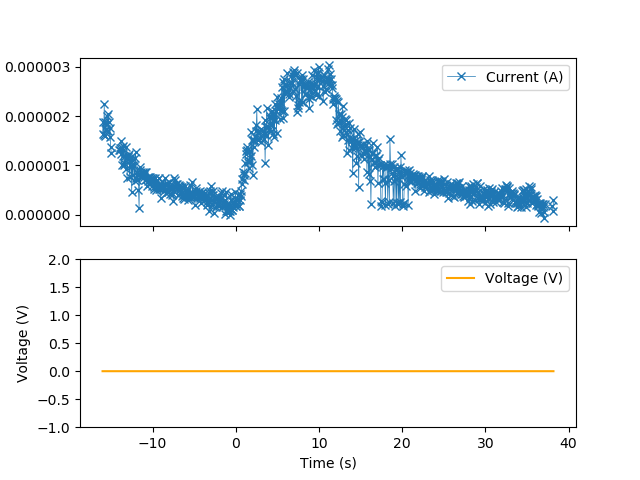

In [71]:
# plot the data
times = gating_data[:, 0]
current = gating_data[:, 1]
voltage = gating_data[:, 2]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], current[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], label='Current (A)', marker="x", linewidth=0.5)
ax1.set_ylabel('Current (A)')
ax1.legend()
ax2.plot(times[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], voltage[np.logical_and(np.abs(voltage)<10,np.abs(current)<10)], label='Voltage (V)', color='orange')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Voltage (V)')
ax2.legend()
plt.ylim(-1, 2)
plt.show()

In [35]:
#############################################################################################################
### Move the blade and sample at the same same time with the same speed - to adjust the initial position!
#############################################################################################################

# Test it here
move_blade_and_sample(7.8753,1)

In [29]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

Starting Alignment
Setting up for Alignment


LimitError: Value 14 outside of range: [-82.08857970400277, 0.0]

In [ ]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='M2_01_angles'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

In [178]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

In [162]:
# Reset x speeds to 1.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

In [173]:
t_coating, t_coating* 9

(2.5555555555555554, 23.0)

In [177]:
###############################################################################################################
# Xu's FAST Blade Coating, No Gating, Huzzah!
###############################################################################################################
# Assumptions:
# 1. You're starting point for running this cell is when the beam is aligned to the blade corner
# 2. The blade is 2mm from the sample edge with solution underneath.
# 3. You've specified the sample width (you can measure it before dispensing using translation).
# 4. You've specified the angle of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################

# sample_name = "X1_01_r01"
sample_name = "Xu_test7_fast_coat"
angle_of_incidence = 0.095
sample_width = 34 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
measurement_time = 0.3 # time per shot.
initial_blade_offset_from_right_edge = 2 #distance of blade from the right edge of the sample (absolute value)
dry_offset = -7 # distance left of blade corner to initial camera position at coating. Should be negative.
time_measuring = 35
# The Blade coating speeds
blade_velocity = 7 #mm/s
stage_velocity_with_blade = -2 #mm/s (maximum is 2)

# Limits
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(stage_velocity_with_blade) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert dry_offset <= 0, f"Initial offset should be left of meniscus (i.e. -ve) - is {dry_offset}"
assert initial_blade_offset_from_right_edge > 0

# Calculate the time taken for the blade to reach the final 5mm of the sample
t_coating = (sample_width - initial_blade_offset_from_right_edge - 5) / (blade_velocity - stage_velocity_with_blade) # t= 33/9 = ~3.3
print(f"The time taken to complete the coating will be {t_coating} s.")
# Calculate the remaining distance that the sample and blade can move to the edge to avoid beam damage.
x_meas = sample_width - (abs(dry_offset)) - initial_blade_offset_from_right_edge - t_coating*abs(stage_velocity_with_blade) - 7 # 7 is 5mm blade final position + 2mm clear of blade.
print(f"The x-measurement length after the coating will be {x_meas}.")
# The inferred stage speed after coating to minimize beam damage on the sample.
stage_speed_after_coat = (x_meas / (time_measuring - t_coating))
assert stage_speed_after_coat > 0.05, f"The measurement coating speed is {stage_speed_after_coat}, should be >=0.05 mm/s to avoid damage..."
assert abs(stage_speed_after_coat) <= MAX_SPEED_STAGE, "Maximum is 2"

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)

# move to dry spot!!
move_blade_and_sample(dry_offset, 0.4) # Move -5 mm for the meniscus, and -2mm for a dry offset!
                          
time.sleep(abs(dry_offset) / 0.4 + 1) # Wait for movement to finish.

# Code to do the initial measurement that is gapless
f_num = file_number.get()
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
fname = sample_name_format_pre.format(sample_name = sample_name, f_num = f_num)
# Run the scan
gi.scan_that_thang(scan_filename=sample_name + "_pre", setup=False, exposure_time=1.0)

# Save the information
if safety_measurement:
    data = {
        "timestamp (s)" : [-5],
        "scan#" : [f_num],
        "filename" : [fname],
        "blade_x (mm)" : [gi.blade_x.position],
        "sample_x (mm)" : [gsaxs.x.position],
    }
else:
    raise ValueError("Not safe to run a measurement. Have you saved data?")

print("Measured the dry point. Starting full measurement in...\n5 s ...")
time.sleep(1)
print("4 s ...")
time.sleep(1)
print("3 s ...")
time.sleep(1)
print("2 s ...")
time.sleep(1)
print("1 s ...")
time.sleep(1)
print("Starting!")
# Start the blade coating!
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)


## Calculate movement of motors for the coating
final_blade_x = init_blade_x + (blade_velocity * t_coating)
final_sample_x = init_sample_x + (stage_velocity_with_blade * t_coating)

# Start shooting
print("Starting fast image acquisition and moving sample...")
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

#### Start the movement of the motors after initializing the camera.
## Set
gi.blade_x.set(final_blade_x, wait=False)
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get()

coating_finished = False
prev_shot_number = f2_num
meas_stage_x = None
meas_blade_x = None
i_coat = None
d1s=[]
d2s=[]
for i in range(num_shots):
    # Ensure we're up to the right scan number.
    if prev_shot_number == -1:
        if i != f2_num:
            continue
        else:
            prev_shot_number = f2_num
    
    while f2_num != i:
        f2_num = frame_number.get()
        time.sleep(0.001)
        if (f2_num > i) and (f2_num != prev_shot_number):
            # The counts have already gone ahead... skip to the correct i.
            prev_shot_number = -1 # Set this as a flag to continue until the correct.
            break
    if prev_shot_number == -1:
        continue
    
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
                          
    # Set the movement of the stage if the coating is finished
    d1 = abs(final_sample_x - gsaxs.x.position)
    d2 = abs(final_blade_x - gi.blade_x.position)
    d1s.append(d1)
    d2s.append(d2)
    if (not coating_finished) and (d1 < 0.01) and (d2 < 0.01):
        coating_finished = True
        
        ## move the sample and the blade forwards
        #speeds
        gi.blade_x.velocity.put(stage_speed_after_coat, wait=True)
        gsaxs.x.velocity.put(stage_speed_after_coat, wait=True)
        
        #Set the new values to current values plus the delta
#         gsaxs.x.set(gsaxs.x.position - x_meas, wait=False) 
#         gi.blade_x.set(gi.blade_x.position - x_meas, wait=False)
        
        # Calculate the positions of the motors for the scan numbers.
        N = num_shots - i
        deltas = np.linspace(0, -x_meas, N)
        
        i_coat = i
        meas_sample_x = gsaxs.x.position + deltas
        meas_blade_x = gi.blade_x.position + deltas
        
        gsaxs.x.set(meas_sample_x[0], wait=False) 
        gi.blade_x.set(meas_blade_x[0], wait=False)
        
    elif coating_finished:
        # Keep moving the position as the detector catches up time wise with delays.
        gsaxs.x.set(meas_sample_x[i-i_coat], wait=False) 
        gi.blade_x.set(meas_blade_x[i-i_coat], wait=False)
    

print("Fast measurement completed.")
plt.plot(d1)
plt.plot(d2)
plt.show()

# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.
print("Taking final `dry` shot after 30s")
time.sleep(30)
angles = [angle_of_incidence]
gi.acquire_angles = angles
gi.X_position_relative_list = [0] * len(angles)
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
f_num = file_number.get()

fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
gi.scan_that_thang(scan_filename=sample_name + "_post", setup=False, exposure_time=1.0)
f2_num = frame_number.get()
data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
data["scan#"].append(f_num)
data["filename"].append(fname)
data["blade_x (mm)"].append(gi.blade_x.position)
data["sample_x (mm)"].append(gsaxs.x.position)
print("Finished")

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)

#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed_with_blade (mm/s)": stage_velocity_with_blade,
            "stage_speed_after_coat (mm/s)": stage_speed_after_coat,
            "blade_speed (mm/s)": blade_velocity,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "dry_offset (mm)" : dry_offset,
            "initial_blade_offset_from_right_edge (mm)": initial_blade_offset_from_right_edge,
            "measurement_time (s)": time_measuring,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")

df


The time taken to complete the coating will be 3.0 s.
The x-measurement length after the coating will be 12.0.
Number of shots 117
Measured the dry point. Starting full measurement in...
5 s ...
4 s ...
3 s ...
2 s ...
1 s ...
Starting!
Starting fast image acquisition and moving sample...
At scan i=0
At scan i=100
Fast measurement completed.
Taking final `dry` shot after 30s
Finished


,timestamp (s),scan#,filename,blade_x (mm),sample_x (mm)
0,-5,1715,Xu_test7_fast_coat_pre_1715.tif,48.89436383875209,24.500305606058724
1,1.8415265083312988,1716,Xu_test7_fast_coat_1716_0001.tif,59.058485879261234,23.92548119771025
2,3.075803518295288,1716,Xu_test7_fast_coat_1716_0002.tif,67.60534146453831,23.43728947396121
3,3.374415874481201,1716,Xu_test7_fast_coat_1716_0003.tif,69.4631374865167,23.303891735474682
4,3.6723899841308594,1716,Xu_test7_fast_coat_1716_0004.tif,69.87436383875209,23.16689405801437
5,3.9815547466278076,1716,Xu_test7_fast_coat_1716_0005.tif,69.88722278044331,23.078295559982873
6,4.289846181869507,1716,Xu_test7_fast_coat_1716_0006.tif,69.89407105596119,22.944297831605294
7,4.588692665100098,1716,Xu_test7_fast_coat_1716_0007.tif,69.89407105596119,22.81190007622085
8,4.897251129150391,1716,Xu_test7_fast_coat_1716_0008.tif,69.89407105596119,22.67930232408188
9,5.196208953857422,1716,Xu_test7_fast_coat_1716_0009.tif,69.89407105596119,22.590503829519363


In [69]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AT THE BEAM POSITION
#############################################################################################################
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
def rule_the_world_new():
    
    #get staring stuff
    starting_blade_x_velocity = gi.blade_x.velocity.get()
    starting_blade_y_velocity = gi.blade_y.velocity.get()
    starting_stage_x_velocity = gsaxs.x.velocity.get()
    starting_blade_x_position = gi.blade_x.position
    starting_blade_y_position = gi.blade_y.position
    starting_stage_x_position = gsaxs.x.position
    
    # Choose the rules of the world
    desired_y_vel = 2 #mm/s
    desired_x_vel = 5 #mm/s
    desired_x_vel_stage = 2 #mm/s
    dry_offset = (sample_width-2)/2
    desired_y_pos = starting_blade_y_position + 10
    desired_x_pos = starting_blade_x_position + 10
    desired_x_pos_blade = starting_stage_x_position - dry_offset
    
    # Check limits
    ylim_low, ylim_high = gi.blade_y.limits
    assert (ylim_low < desired_y_pos) and (desired_y_pos < ylim_high), "High limit for Y!"
    xlim_low, xlim_high = gi.blade_x.limits
    assert (xlim_low < desired_x_pos) and (desired_x_pos < xlim_high), "High limit for X!"

    # Set the velocities to move
    gi.blade_x.velocity.put(desired_x_vel)
    gi.blade_y.velocity.put(desired_y_vel)
    gsaxs.x.velocity.put(desired_x_vel_stage)
    
    # Move
    gi.blade_y.set(desired_y_pos, wait=True)
    gi.blade_x.set(desired_x_pos, wait=True)
    gsaxs.x.set(desired_x_pos_blade, wait=True)
    
#     e = None
#     try:
    # Run the alingment
    gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
    
#     except Exception as e:
#         pass
    
    # Return the blade at a slow velocity
#     gi.blade_y.velocity.put(2)
    gi.blade_x.set(starting_blade_x_position, wait=True)
    gi.blade_y.set(starting_blade_y_position, wait=True)
    gsaxs.x.set(starting_stage_x_position, wait = True)
    
    # Return the velocities
    gi.blade_x.velocity.put(starting_blade_x_velocity)
    gi.blade_y.velocity.put(starting_blade_y_velocity)
    gsaxs.x.velocity.put(starting_stage_x_velocity)
    
#     if e:
#         raise e
    
rule_the_world_new()

Starting Alignment
Setting up for Alignment
Feedback camera tuning successful.


TimeoutError: 

Starting Alignment
Setting up for Alignment
Final feedback results for setup_for_acquire were [200.03, 199.18, 214, 0.08, 10.0]
Finished Setting up for Alignment
retries = 0
Positioning done by set_feedback function
Full_beam_counts: 357108
Height Scan Halvies
Running halvies_rel_height_scan4


Halvies scan range from 1.3155 to,  4.3155
beam_counts = 357108
fractional_intensity_target = 0.5
i =  0 height =  2.8155 counts =  355729
i =  1 height =  3.5655 counts =  1
i =  2 height =  3.1905 counts =  354934
i =  3 height =  3.378 counts =  57
i =  4 height =  3.2845 counts =  353861
i =  5 height =  3.331 counts =  351452
i =  6 height =  3.3545 counts =  16731
i =  7 height =  3.3425 counts =  181517
i =  8 height =  3.3485 counts =  64256
i =  9 height =  3.3455 counts =  122420
i =  10 height =  3.344 counts =  150202
final aligned position = 3.3435 final aligned counts = 157879 fractional_intensity target = 0.5


<IPython.core.display.Javascript object>


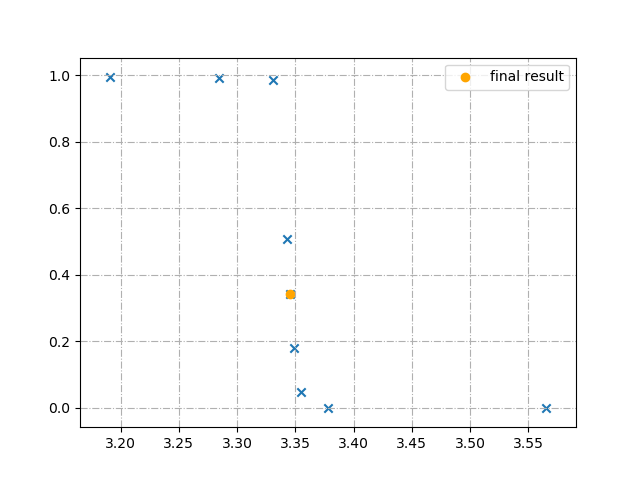

Counts: 156002, Target: 178554
Running Coarse Omega Scan
gimme_omega_data= <GSAXS_invac_class_15a_for_general_use.Gimme_Omega_Data object at 0x7f71dc3c5828>


<IPython.core.display.Javascript object>


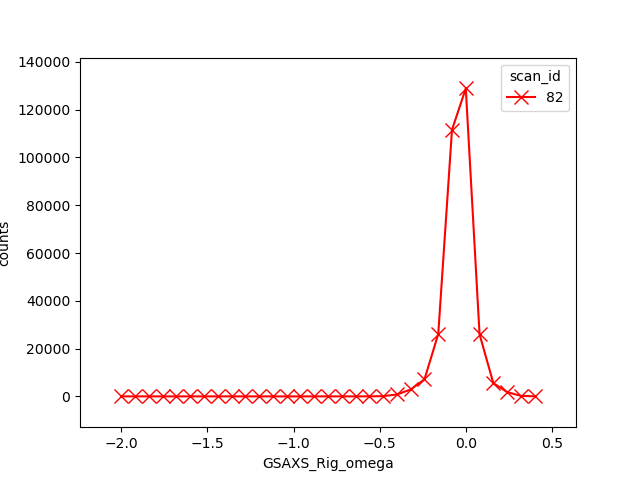

OmegaAnalysis: points at max = []
omega_scan2: omega_analysis.com = -0.00033395688572485094
omega_scan2: omega_analysis.mid_plateau = None 4
com
moving to centre of omega scan at -0.00033395688572485094 degrees
Coarse scan peaked at 36.1 % of full flux.
Running Fine Omega Scan
auto_fine_scan_range=  (-0.29, 0.15, 41, 0.011)


<IPython.core.display.Javascript object>


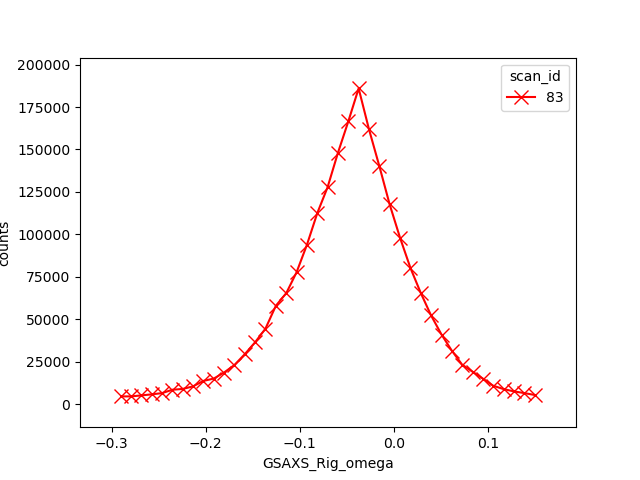

Trying to run stop method
OmegaAnalysis: points at max = []
fitting Gauss slicing parameters
angle at highest intensity = -0.0374320703088053
beam height, mm = 0.013 +/- 0
beam height, microns = 12.5 +/- 0
sample length, mm = 8.202 +/- 0.113
sample height displacement, mm = -0.00083 +/- 5.7e-05
sample height displacement, microns = -0.83 +/- 0.0575
sample z displacement, mm = 0.356 +/- 0.356
sample pitch offset, degree = -0.037432 +/- 0.000793
at line 2079, omega_fine_analysis.mid_plateau =  None


<IPython.core.display.Javascript object>


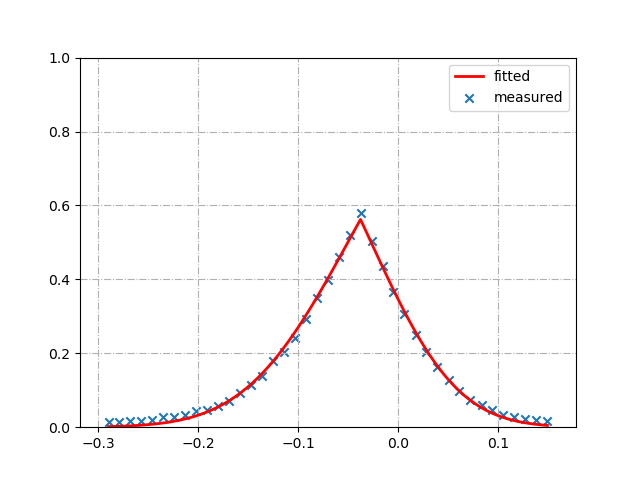

Succeeded because control sample z displacement set to False
Before adjusting hxp.y (/ sample height) from sample height fit, I was at 3.3435
Moved sample height to fitted position of  3.3445 

moving to centre of omega scan at -0.0374 degrees
After adjusting hxp.y (/sample height) from sample height fit, I am at 3.3445
s2[0] = True 

type of s2[0] = <class 'bool'>
control_sample_z_displacement =  False
Successful Alignment!
Final Halvies Height Scan
Final Halvies Height Scan
Running halvies_rel_height_scan4


Halvies scan range from 3.307 to,  3.382
beam_counts = 357108
fractional_intensity_target = 0.5
i =  0 height =  3.3445 counts =  155867
i =  1 height =  3.307 counts =  349119
i =  2 height =  3.3255 counts =  353255
i =  3 height =  3.335 counts =  325471
i =  4 height =  3.34 counts =  243486
i =  5 height =  3.3425 counts =  179735
i =  6 height =  3.3435 counts =  162816
i =  7 height =  3.343 counts =  170992
final aligned position = 3.3425 final aligned counts = 180534 fra

<IPython.core.display.Javascript object>


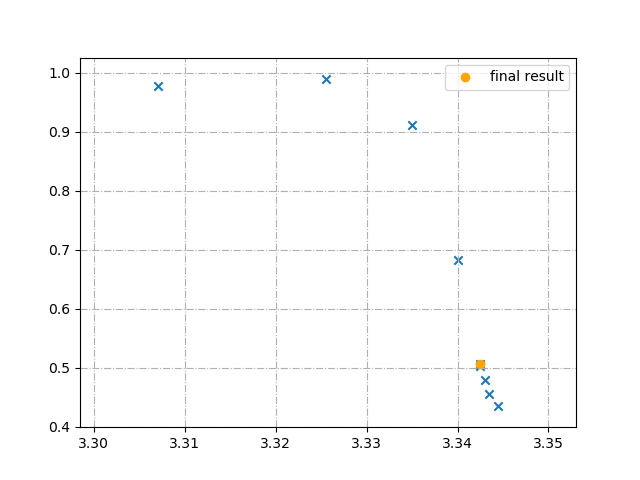

Counts: 177227, Target: 178554
Rezero Omega
nk_final_counts 177227 nk_final_target 178554
Finished alignment successfully. Woot!
Setup for acquisition after align = True
Setting up for Acquisition
Final feedback results for setup_for_acquire were [199.39, 199.86, 238, 0.05, 0.2]
Finished Setting up for Acquisition
YAY DONE!


In [7]:
#############################################################################################################
### 01 PERFORM A SAFE SAMPLE ALIGNMENT!
### RUN THIS IF THE BLADE IS AWAY FROM THE BEAM POSITION (ESPECIALLY HEIGHT)
#############################################################################################################
gi.align_and_scan_that_thang_halvies(scan_filename = 'no_filename', skip_scan = True, control_sample_z_displacement=False)
print("YAY DONE!")

In [18]:
#############################################################################################################
# DEFINE A VARIABLE THAT WILL STOP A RUN FROM COMPLETEING AND OVERRIDING THE DATA VARIABLES-SAFETY MEASUREMENT CHECK.
#############################################################################################################
import pandas as pd, numpy as np, matplotlib.pyplot as plt
safety_measurement = True
"""True if it's safe to record a measurement, False if a measurement is complete and data exists."""

"True if it's safe to record a measurement, False if a measurement is complete and data exists."

The time taken to complete the coating will be 3.6666666666666665 s.
The x-measurement length after the coating will be 21.666666666666668.
Number of shots 661
 Starting full measurement in...
5 s ...
4 s ...
3 s ...
2 s ...
1 s ...
Starting!
stage velocity EpicsSignal(read_pv='SR13ID01:GSAX_X.VELO', name='GSAXS_Rig_x_velocity', parent='GSAXS_Rig_x', value=2.0, timestamp=1753618206.124671, tolerance=0.0001, auto_monitor=True, string=False, write_pv='SR13ID01:GSAX_X.VELO', limits=False, put_complete=False)
stage velocity EpicsSignal(read_pv='SR13ID01:GSAX_X.VELO', name='GSAXS_Rig_x_velocity', parent='GSAXS_Rig_x', value=2, timestamp=1753618212.133212, tolerance=0.0001, auto_monitor=True, string=False, write_pv='SR13ID01:GSAX_X.VELO', limits=False, put_complete=False)
Starting fast image acquisition and moving sample...
Missed frame 0, skipping record
Missed frame 1, skipping record
Missed frame 2, skipping record
Missed frame 3, skipping record
Missed frame 4, skipping record
end positi

Run aborted
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1160, in baseline_wrapper
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/prepr

Taking `dry` shot after 60s


Run aborted
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1160, in baseline_wrapper
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/prepr

Taking `dry` shot after 90s


Run aborted
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1160, in baseline_wrapper
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/prepr

Taking `dry` incident angle scan after 120 s
Finished waiting final shot...


Run aborted
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 1160, in baseline_wrapper
    return (yield from plan)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 803, in monitor_during_wrapper
    return (yield from plan2)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 123, in plan_mutator
    msg = plan_stack[-1].send(ret)
  File "/opt/conda/lib/python3.7/site-packages/bluesky/preprocessors.py", line 170, in plan_mutator
    raise ex
  File "/opt/conda/lib/python3.7/site-packages/bluesky/prepr

<IPython.core.display.Javascript object>


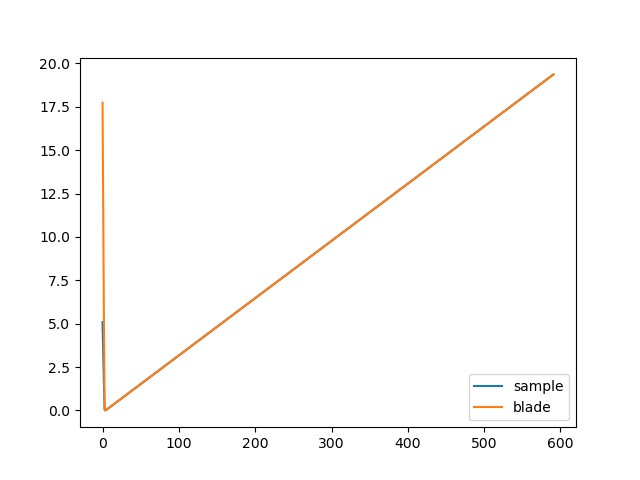

<IPython.core.display.Javascript object>


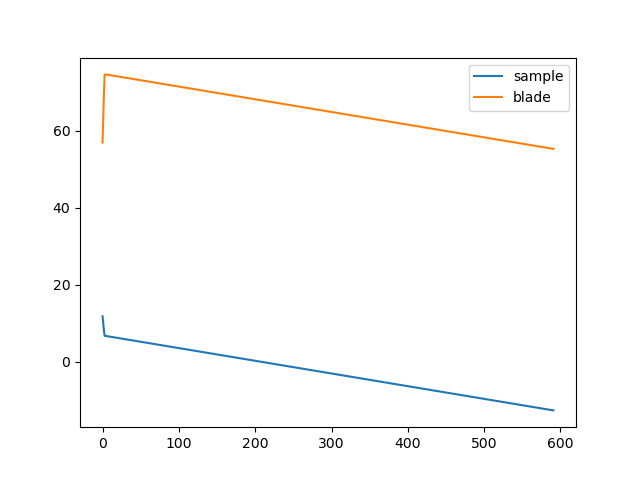

,timestamp (s),scan#,filename,blade_x (mm),sample_x (mm)
0,7.4531495571136475,2348,X1_10_r04_2348_0006.tif,56.93044284071419,11.758017495922331
1,8.35005259513855,2348,X1_10_r04_2348_0007.tif,63.17783727939818,9.973047626666311
2,9.258167505264282,2348,X1_10_r04_2348_0008.tif,69.36923266406748,8.20407748726714
3,10.154757261276245,2348,X1_10_r04_2348_0009.tif,74.55095392610954,6.700960401645926
4,11.059481382369995,2348,X1_10_r04_2348_0010.tif,74.66547422601828,6.666669403317574
5,11.97163438796997,2348,X1_10_r04_2348_0011.tif,74.6487645430363,6.649212863321045
6,12.877577543258667,2348,X1_10_r04_2348_0012.tif,74.61954353759654,6.619991857732276
7,13.773524761199951,2348,X1_10_r04_2348_0013.tif,74.5901245353616,6.590572855497339
8,14.679170846939087,2348,X1_10_r04_2348_0014.tif,74.55732309023506,6.557771410519818
9,15.584323167800903,2348,X1_10_r04_2348_0015.tif,74.52793708751565,6.528385407651404


In [27]:
# # Xu's FAST Blade Coating, No Gating, Huzzah! MODIFIED W/O MATT.
###############################################################################################################
# Assumptions:
# 1. You're starting point for running this cell is when the beam is aligned to the blade corner
# 2. The blade is 2mm from the sample edge with solution underneath.
# 3. You've specified the sample width (you can measure it before dispensing using translation).
# 4. You've specified the angle of incidence
# 5. The blade will stop moving 5mm from the end of the sample.
###############################################################################################################
import time  

sample_name = "X1_10_r04"
angle_of_incidence = 0.1
sample_width = 40 # MEASURE THIS! Commented values listed below for example are assuming sample_width = 40.
measurement_time = 0.5 # time per shot.
initial_blade_offset_from_right_edge = 2 #distance of blade from the right edge of the sample (absolute value)
dry_offset = -7 # distance left of blade corner to initial camera position at coating. Should be negative.
time_measuring = 330 # 8 mins
# The Blade coating speeds
blade_velocity = 7 #mm/s
stage_velocity_with_blade = -2 #mm/s (maximum is 2)
post_measurement_image_intervals = [30, 30, 30] # The times to consecutively wait and take extra gapless images after the main fast sequence.
post_measurement_angle_scan_interval = 30 #consecutive time to wait for angle scan

# Limits
MAX_SPEED_BLADE = 7
MAX_SPEED_STAGE = 2
assert abs(stage_velocity_with_blade) <= MAX_SPEED_STAGE, "Maximum is 2"
assert abs(blade_velocity) <= MAX_SPEED_BLADE, "Maximum is 7"
assert dry_offset <= 0, f"Initial offset should be left of meniscus (i.e. -ve) - is {dry_offset}"
assert initial_blade_offset_from_right_edge > 0

# Calculate the time taken for the blade to reach the final 5mm of the sample
t_coating = (sample_width - initial_blade_offset_from_right_edge - 5) / (blade_velocity - stage_velocity_with_blade) # t= 33/9 = ~3.3
print(f"The time taken to complete the coating will be {t_coating} s.")
# Calculate the remaining distance that the sample and blade can move to the edge to avoid beam damage.
x_meas = sample_width - (abs(dry_offset)) - initial_blade_offset_from_right_edge - t_coating*abs(stage_velocity_with_blade) - 9 # 9 is 5mm blade final position + 4mm clear of blade.
print(f"The x-measurement length after the coating will be {x_meas}.")
# The inferred stage speed after coating to minimize beam damage on the sample.
stage_speed_after_coat = (x_meas / (time_measuring - t_coating)) * 0.5 # Add an extra factor to reduce speed as the detector has some delay in image taking.
assert stage_speed_after_coat > 0.015, f"The measurement coating speed is {stage_speed_after_coat}, should be >=0.05 mm/s to avoid damage..."
assert abs(stage_speed_after_coat) <= MAX_SPEED_STAGE, "Maximum is 2"

# Calculate number of shots and start shooting
num_shots = int((time_measuring) // measurement_time + 1)
print(f"Number of shots {num_shots}")

if num_shots > 1000:
    raise ValueError(f"Do you really want to take {num_shots} shots?")

if not safety_measurement:
    raise ValueError("Not safe to run a measurement. Have you saved data?")
    
# Setup the formats for the filenames
sample_name_format_pre = "{sample_name}_pre_{f_num:04d}.tif"
sample_name_format_frame = "{sample_name}_{f_num:04d}_{f2_num:04d}.tif"
sample_name_format_post = "{sample_name}_post_{f_num:04d}.tif"

# Setup
gi.pitch_motor.move(angle_of_incidence, wait = True)
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(stage_velocity_with_blade)

# move to dry spot!!
move_blade_and_sample(dry_offset, 1.99) # Move -5 mm for the meniscus, and -2mm for a dry offset!
                          
time.sleep(abs(dry_offset) / 1.99 + 1) # Wait for movement to finish.

# Save the information
if safety_measurement:
   data = {
       "timestamp (s)" : [],
       "scan#" : [],
       "filename" : [],
       "blade_x (mm)" : [],
       "sample_x (mm)" : [],
   }
else:
   raise ValueError("Not safe to run a measurement. Have you saved data?")

#print("Measured the dry point.") 
print(" Starting full measurement in...\n5 s ...")
time.sleep(1)
print("4 s ...")
time.sleep(1)
print("3 s ...")
time.sleep(1)
print("2 s ...")
time.sleep(1)
print("1 s ...")
time.sleep(1)
print("Starting!")
# Start the blade coating!
start_time = time.time()

# Record the intial positions
init_blade_x = gi.blade_x.position
init_sample_x = gsaxs.x.position

print(f"stage velocity {gsaxs.x.velocity}")
# Make motors move from their initial position!
## Blade speed
gi.blade_x.velocity.put(blade_velocity)
## Stage speed
gsaxs.x.velocity.put(abs(stage_velocity_with_blade))


#print(f"blade velocity {gi.blade_x.velocity}")
print(f"stage velocity {gsaxs.x.velocity}")

## Calculate movement of motors for the coating
final_blade_x = init_blade_x + (blade_velocity * t_coating)
final_sample_x = init_sample_x + (stage_velocity_with_blade * t_coating)

# Start shooting
print("Starting fast image acquisition and moving sample...")
fast_GI_scan_multi_shot(filename = sample_name, exposure_time = measurement_time, number_shots=num_shots)

time.sleep(6)

#### Start the movement of the motors after initializing the camera.
## Set
gi.blade_x.set(final_blade_x, wait=False)
gsaxs.x.set(final_sample_x, wait=False)

# Run a scan loop, simulating when each shot will happen, and then poll the positions etc.
f_num = file_number.get()
f2_num = frame_number.get() # Number becomes 0  when frame starts, 1 when frame ends. 

coating_finished = False
meas_stage_x = None
meas_blade_x = None
i_coat = None
d1s=[]
d2s=[]
pos1=[]
pos2=[]
times=[]

changing_frame = False # Have we changed frame number yet? at all? 
initial_f2_num = f2_num
for i in range(num_shots):
    # Get the current frame number.
    f2_num = frame_number.get() # Get the current number.
    t = time.time()
    
    # Are we changing frames yet?
    while not changing_frame:
        f2_num = frame_number.get() # Get the current number.
        if f2_num != initial_f2_num:
            changing_frame = True
        time.sleep(0.01)
    
    # Skip to current frame
    if i <= f2_num:
        print(f"Missed frame {i}, skipping record")
        continue
        
    while f2_num != i:
        time.sleep(0.01)
        f2_num = frame_number.get() # Get the current number.
        
    # Print the number if we hit a multiple of 50!
    if (i%50)==0:
      print(f"At scan i={i}")
    
    # Now measuring shot #i
    t = time.time()
    
    # Params)
    curr_blade_x = gi.blade_x.position
    curr_sample_x = gsaxs.x.position
    fname = sample_name_format_frame.format(sample_name=sample_name, f_num=f_num, f2_num=f2_num+1) # End of the measurement is the filenumber
    
    # Save the record
    data["timestamp (s)"].append(t - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num) #
    data["filename"].append(fname)
    data["blade_x (mm)"].append(curr_blade_x)
    data["sample_x (mm)"].append(curr_sample_x)
                          
    # Set the movement of the stage if the coating is finished
    d1 = abs(final_sample_x - gsaxs.x.position)
    d2 = abs(final_blade_x - gi.blade_x.position)
    d1s.append(d1)
    d2s.append(d2)
    pos1.append(gsaxs.x.position)
    pos2.append(gi.blade_x.position)
    times.append(time.time())
    
    # Have we finished coating? Do a check, calculate the translation required.
    if (not coating_finished) and (d1 < 0.01) and (d2 < 0.01):
        print(f"end position reached with d1={d1} and d2={d2}, i={i}")
        coating_finished = True
        
        ## move the sample and the blade forwards
        #speeds
        gi.blade_x.velocity.put(stage_speed_after_coat, wait=True)
        gsaxs.x.velocity.put(stage_speed_after_coat, wait=True)
        
        #print(f"blade velocity {gi.blade_x.velocity}")
        #print(f"stage velocity {gsaxs.x.velocity}")
        
        #Set the new values to current values plus the delta
        gsaxs.x.set(gsaxs.x.position - x_meas, wait=False) 
        gi.blade_x.set(gi.blade_x.position - x_meas, wait=False)
        
#         # Calculate the positions of the motors for the scan numbers.
#         N = num_shots - i
#         deltas = np.linspace(0, -x_meas, N)
        
#         i_coat = i
#         meas_sample_x = gsaxs.x.position + deltas
#         meas_blade_x = gi.blade_x.position + deltas
        
#         gsaxs.x.set(meas_sample_x[0], wait=False) 
#         gi.blade_x.set(meas_blade_x[0], wait=False)
        
    # We have finished coating! Use the calculated steps to move.
#     elif coating_finished:
#         # Keep moving the position as the detector catches up time wise with delays.
#         gsaxs.x.set(meas_sample_x[i-i_coat], wait=False) 
#         gi.blade_x.set(meas_blade_x[i-i_coat], wait=False)
    

print("Fast measurement completed.")


# TAKE ONE LAST IMAGE another 30s later for clarity on what's been measured.
post_time = 0
for post_time_offset in post_measurement_image_intervals:
    # Accumulate
    post_time += post_time_offset
    
    # Measure
    print(f"Taking `dry` shot after {post_time}s")
    time.sleep(post_time_offset)
    angles = [angle_of_incidence]
    gi.acquire_angles = angles
    gi.X_position_relative_list = [-0.05] * len(angles)
    gi.beamstop_positions = [gi.beamstop_height] * len(angles)
    f_num = file_number.get()

    fname = sample_name_format_post.format(sample_name = sample_name, f_num = f_num)
    gi.scan_that_thang(scan_filename=sample_name + f"_post_{post_time}s", setup=False, exposure_time=1.0)
    f2_num = frame_number.get()
    data["timestamp (s)"].append(time.time() - start_time) # Take the average in-between time of the measurement.
    data["scan#"].append(f_num)
    data["filename"].append(fname)
    data["blade_x (mm)"].append(gi.blade_x.position)
    data["sample_x (mm)"].append(gsaxs.x.position)



#############################################################################################################
# Record the data in a table!
#############################################################################################################
raw_data = np.array([col
       for col in data.values()]).T
header = list(data.keys())

# Create a pandas dataframe.
df = pd.DataFrame(raw_data, columns=header)
# Save the data to file - generate the base name and directory.
cwd = os.getcwd()
save_dir = os.path.join(cwd, "McNeill_23899_InSitu")
save_filename = os.path.join(save_dir, sample_name)

# Settings save
settings_name = save_filename + "_settings.txt"
if not os.path.exists(settings_name):
    with open(settings_name, "w") as settingsfile:
        settingsfile.write("Parameter (unt)\tValue\n")
        settings = {
            "stage_speed_with_blade (mm/s)": stage_velocity_with_blade,
            "stage_speed_after_coat (mm/s)": stage_speed_after_coat,
            "blade_speed (mm/s)": blade_velocity,
            "measurement_interval (s)" : measurement_time,
            "angle_of_incidence (deg)" : angle_of_incidence,
            "dry_offset (mm)" : dry_offset,
            "initial_blade_offset_from_right_edge (mm)": initial_blade_offset_from_right_edge,
            "measurement_time (s)": time_measuring,
        }
        for key, val in settings.items():
            settingsfile.write(key + "\t" + str(val) + "\n")
else:
    # Save the settings
    print(f"FILE `{settings_name}` ALREADY EXISTS")
           
# Save the data frame
csv_name = save_filename + ".csv"
txt_name = save_filename + ".txt"
if not os.path.exists(csv_name):
    df.to_csv(csv_name, index=False) 
else: 
    print(f"FILE `{csv_name}` ALREADY EXISTS")
if not os.path.exists(txt_name):
    df.to_csv(txt_name, index=False, sep="\t")
else:
    print(f"FILE `{txt_name}` ALREADY EXISTS")

#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################
post_time += post_measurement_angle_scan_interval
print(f"Taking `dry` incident angle scan after {post_time} s")
time.sleep(post_measurement_angle_scan_interval)
print("Finished waiting final shot...")
scan_filename=f'{sample_name}_post_{post_time}s_angle_scan'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

print

# Set the safety switch!
safety_measurement = False
# Put some default movement speeds.
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)



times=np.array(times)
d1s=np.array(d1s)
d2s=np.array(d2s)
fig,ax = plt.subplots()
ax.plot(times-times[0],d1s,label="sample")
ax.plot(times-times[0],d2s,label="blade")
plt.legend()
plt.show()

pos1=np.array(pos1)
pos2=np.array(pos2)
fig,ax = plt.subplots()
ax.plot(times-times[0],pos1,label="sample")
ax.plot(times-times[0],pos2,label="blade")
plt.legend()
plt.show()


    
df


In [95]:
gi.blade_x.velocity.put(1)
gsaxs.x.velocity.put(1)
f2_num, frame_number.get(), i


(3, 3, 599)

In [10]:
#############################################################################################################
### SCANNING ANGLE OF INCIDENCE SHIFTING.
#############################################################################################################

scan_filename='X01_09_r01_angle_scan2'

# Setup angles

angles = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.12, 0.13]
gi.acquire_angles = angles

# Setup other movement variables based on number of angles
position_shift_per_angle = -0.05
gi.X_position_relative_list = [position_shift_per_angle*i for i in range(len(gi.acquire_angles))]
gi.beamstop_positions = [gi.beamstop_height] * len(angles)
gi.scan_that_thang(scan_filename=scan_filename, setup=False, exposure_time=1.0)

<IPython.core.display.Javascript object>


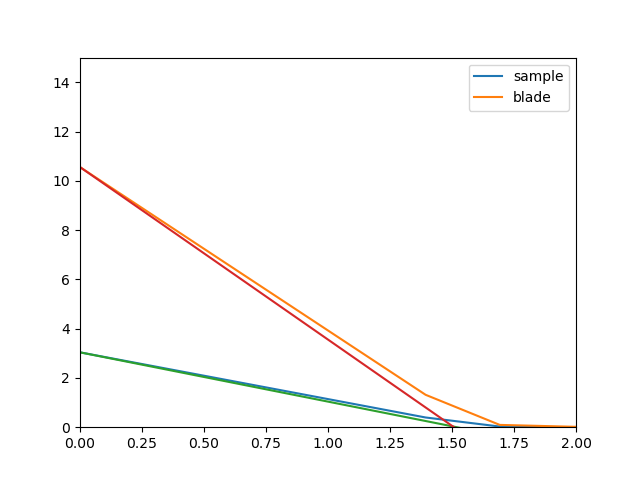

In [211]:
times=np.array(times)
d1s=np.array(d1s)
d2s=np.array(d2s)
timeshift=times-times[0]
fig,ax = plt.subplots()
ax.plot(timeshift,d1s,label="sample")
ax.plot(timeshift,d2s,label="blade")
ax.plot(timeshift,d1s[0]-2*timeshift)
ax.plot(timeshift,d2s[0]-7*timeshift)
ax.plot()
ax.set_xlim(0,2)
ax.set_ylim(0,15)
plt.legend()
plt.show()

In [ ]:
#temperature loop
#Update temperatures here too

#heating_list = [31, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190]
#cooling_list = [100, 75, 50, 25, 0, -15, -30, -40, -50, -55, -60, -65, -70, -75]
def run_julian_heating_series(filename,  input_list = [], acquire_angle = 1, use_calculated_height = False, align_height_at_each_temp = False, run_gapless = True, temp_offset = 5):
    #gi.acquire_det_y = 35  
    initial_sample_height = gi.fine_y_motor.position
    initial_temperature = usbtemp1.t2.get()
    print('At start, temperature was', round(initial_temperature, 2), 'initial height was', round(initial_sample_height, 3))

    for temperature_point in input_list:
        #clear_output()
        print('running sample at temperature', temperature_point)
        while ((usbtemp1.t2.get() < temperature_point - temp_offset)) :
            sleep(4)
        #realign_height
        
        if align_height_at_each_temp == True:
            clear_output()
            print('running sample at temperature', temperature_point)
            gi.align_and_scan_that_thang_halvies("fred_flinstone", skip_scan = True,
                                         skip_coarse_omega = True,
                                         skip_fine_omega = True,
                                         control_sample_z_displacement = False, 
                                         sample_z_displacement_deadband = 5)
        
        current_temperature = usbtemp1.t2.get()
        if use_calculated_height == True:
            # move sample to calculated height
            height_correction = (7.911815E-07 * current_temperature **2 ) - (9.714884E-04 * current_temperature) + 2.327824E-02
            print('At', round(current_temperature, 2), 'degrees C, height_correction= ', round(height_correction, 3), '\n')
            temp_corrected_height = initial_sample_height + height_correction
            gi.fine_y_motor.move(temp_corrected_height, wait = True)
            
        gi.pitch_motor.move(acquire_angle, wait = True)
        
        current_temperature_name = '_'+ str("{:.3f}".format(current_temperature)).replace('.', 'p')
        current_filename =  filename + current_temperature_name
        
        gi.x_motor.relmv(gi.julian_temp_ramp_per_temp_x_movement)              
        

        
        if run_gapless == True:
            per_step = gps.per_step_gapless_video_1xshutter
            positions = [0]
            inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)
            
            plan = partial(gapless_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=0.1,
                       use_feedback=True,
                       open_shutter=False) 

            sa.queue({"type": "plan", "data": plan}, wait=True)
        if run_gapless == False:
            saxs_det.x.move(gi.acquire_det_x, wait = True)
            saxs_det.y.move(gi.acquire_det_y, wait = True)
            per_step = sps.per_step_with_shutter_feedback_video
            positions = [0]
            inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)  

            plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=1,
                       use_feedback=True,
                       open_shutter=False) 

            sa.queue({"type": "plan", "data": plan}, wait=True)

def run_julian_cooling_series(filename,  input_list = [], acquire_angle = 1, use_calculated_height = False, align_height_at_each_temp = False, run_gapless = True, temp_offset = 5):
    
    initial_sample_height = gi.fine_y_motor.position
    initial_temperature = usbtemp1.t2.get()
    print('At start, temperature was', round(initial_temperature, 2), 'initial height was', round(initial_sample_height, 3))

    for temperature_point in input_list:
        #clear_output()
        print('running sample at temperature', temperature_point)
        while ((usbtemp1.t2.get() > temperature_point - temp_offset)) :
            sleep(1)
        #realign_height
        
        if align_height_at_each_temp == True:
            clear_output()
            print('running sample at temperature', temperature_point)
            gi.align_and_scan_that_thang_halvies("fred_flinstone", skip_scan = True,
                                         skip_coarse_omega = True,
                                         skip_fine_omega = True,
                                         control_sample_z_displacement = False, 
                                         sample_z_displacement_deadband = 5)
        
        current_temperature = usbtemp1.t2.get()
        if use_calculated_height == True:
            # move sample to calculated height
            height_correction = (7.911815E-07 * current_temperature **2 ) - (9.714884E-04 * current_temperature) + 2.327824E-02
            print('At', round(current_temperature, 2), 'degrees C, height_correction= ', round(height_correction, 3), '\n')
            temp_corrected_height = initial_sample_height + height_correction
            gi.fine_y_motor.move(temp_corrected_height, wait = True)
            
        gi.pitch_motor.move(acquire_angle, wait = True)
        
        current_temperature_name = '_'+ str("{:.3f}".format(current_temperature)).replace('.', 'p')
        current_filename =  filename + current_temperature_name
        
        gi.x_motor.relmv(gi.julian_temp_ramp_per_temp_x_movement)              
        
        if run_gapless == True:
            per_step = gps.per_step_gapless_video_1xshutter
            positions = [0]
            inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)
            
            plan = partial(gapless_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=0.2,
                       use_feedback=True,
                       open_shutter=False) 

            sa.queue({"type": "plan", "data": plan}, wait=True)
        if run_gapless == False:
            saxs_det.x.move(gi.acquire_det_x, wait = True)
            saxs_det.y.move(gi.acquire_det_y, wait = True)
            per_step = sps.per_step_with_shutter_feedback_video
            positions = [0]
            inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)  

            plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=1,
                       use_feedback=True,
                       open_shutter=False) 

            sa.queue({"type": "plan", "data": plan}, wait=True)

def run_julian_fast(filename,  acquire_angle = 1, use_calculated_height = True, run_gapless = True):
    
    initial_sample_height = gi.fine_y_motor.position
    initial_temperature = usbtemp1.t2.get()
    print('At start, temperature was', round(initial_temperature, 2), 'initial height was', round(initial_sample_height, 3))

    while True :

        #realign_height
        sleep(4) # this is good !
               
        current_temperature = usbtemp1.t2.get()
        if use_calculated_height == True:
            # move sample to calculated height
            #height_correction = (7.911815E-07 * current_temperature **2 ) - (9.714884E-04 * current_temperature) + 2.327824E-02
            height_correction = -8.5044E-04 * current_temperature
            print('At', round(current_temperature, 2), 'degrees C, height_correction= ', round(height_correction, 3), '\n')
            #temp_corrected_height = initial_sample_height + height_correction
            temp_corrected_height = height_correction
            gi.fine_y_motor.move(temp_corrected_height, wait = True)
            
        gi.pitch_motor.move(acquire_angle, wait = True)
        
        current_temperature_name = '_'+ str("{:.3f}".format(current_temperature)).replace('.', 'p')
        current_filename =  filename + current_temperature_name
        
        gi.x_motor.relmv(gi.julian_temp_ramp_per_temp_x_movement)              
        
        per_step = gps.per_step_gapless_video_1xshutter
        
        if run_gapless == True:
            per_step = gps.per_step_gapless_video_1xshutter
            positions = [0]
            inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)
            
            plan = partial(gapless_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=0.2,
                       use_feedback=True,
                       open_shutter=False) 

            sa.queue({"type": "plan", "data": plan}, wait=True)
        if run_gapless == False:
            saxs_det.x.move(gi.acquire_det_x, wait = True)
            saxs_det.y.move(gi.acquire_det_y, wait = True)            
            per_step = sps.per_step_with_shutter_feedback_video
            positions = [0]
            inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)  

            plan = partial(gappy_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=1,
                       use_feedback=True,
                       open_shutter=False) 

            sa.queue({"type": "plan", "data": plan}, wait=True)
                        
      





    

def take_single_shot_at_an_angle(filename,  acquire_angle = 1):
        gi.pitch_motor.move(acquire_angle, wait = True)
        
        current_temperature_name = '_'+ str("{:.3f}".format(usbtemp1.t2.get())).replace('.', 'p')
        current_filename =  filename + current_temperature_name      
        
        per_step = gps.per_step_gapless_video_1xshutter
        positions = [0]
        inner_plan = rel_list_scan(detectors, gi.x_motor, positions, per_step=per_step)
        plan = partial(gapless_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=1,
                       use_feedback=True,
                       open_shutter=False) 

        sa.queue({"type": "plan", "data": plan}, wait=True)
        
        
'''def run_cooling_series(input_list):
    for temperature_point in input_list:
        print('running sample at temperature', temperature_point)
        while ((usbtemp1.t2.get() > temperature_point)) :
            sleep(1)
        current_temperature_name = '_'+ str("{:.3f}".format(usbtemp1.t2.get())).replace('.', 'p')
        current_filename =  filename + current_temperature_name
        in_vac.x.relmv(0.2)                                  

        per_step = gps.per_step_gapless_video_1xshutter
        positions = [0]
        inner_plan = rel_list_scan(detectors, in_vac.x, positions, per_step=per_step)
        plan = partial(gapless_plan,
                       inner_plan,
                       filename=Path(current_filename),
                       exp_time=1,
                       use_feedback=True,
                       open_shutter=False) 

        sa.queue({"type": "plan", "data": plan}, wait=True)  

        
'''        
def run_heating_series_2(input_list, sample_coordinates, heating_tolerance = 2, position_shift_between_temperatures = 0.5):
    for index, temperature_point in enumerate(input_list): 
        print('Waiting for sample to reach temperature', temperature_point)
        while ((usbtemp1.t2.get() < temperature_point- heating_tolerance)) :
            sleep(1)
        print('Temperature now at ', usbtemp1.t2.get(), 'sleeping 5 seconds')    
        sleep(5)
        print('running sample at temperature', temperature_point)
        for position in sample_coordinates:
            current_temperature_name = '_'+ str("{:.1f}".format(usbtemp1.t2.get())).replace('.', 'p')
            current_filename =  position[0] + current_temperature_name
            in_vac.x.move(position[1] + index * (position_shift_per_angle*(len(input_list)-1) + position_shift_between_temperatures), wait = True)
            gi.scan_that_thang_from_dial(current_filename, position[2], position[3])
    print('Done!')


def run_time_voltage_series(input_time_list, filename = 'expensive_sample', use_second_detector_position = False):
    saxs_det.x.move(gi.acquire_det_x, wait = True)
    saxs_det.y.move(gi.acquire_det_y, wait = True)
    start_time = time()
    starting_x = in_vac.x.position
    for index, time_point in enumerate(input_time_list):
        in_vac.x.move(starting_x)
        print('Waiting for time_to_reach target time', time_point)

        while (time() - start_time < time_point) :
            sleep(1)
        print('Reached timepoint ', time_point, '.Running sample.')    
        if use_second_detector_position == True:
            saxs_det.x.move(gi.acquire_det_x, wait = True)
            saxs_det.y.move(gi.acquire_det_y, wait = True)
            current_filename = filename  + '_'+ str("{:.1f}".format((time() - start_time) / 60)) .replace('.', 'p') + 'm'
            gi.scan_that_thang(current_filename)
            
            saxs_det.x.move(gi.acquire_det_x_2, wait = True)
            saxs_det.y.move(gi.acquire_det_y_2, wait = True)
            gi.scan_that_thang(current_filename)
        else:     
            gi.scan_that_thang(current_filename)

            
    print('Done!')    
    
    
def run_isothermal_sample_group(sample_coordinates):
        
    for position in sample_coordinates:
        current_temperature_name = '_'+ str("{:.1f}".format(usbtemp1.t2.get())).replace('.', 'p')
        current_filename =  position[0] + current_temperature_name
        in_vac.x.move(position[1], wait = True)
        gi.scan_that_thang_from_dial(current_filename, position[2], position[3])

        in_vac.x.relmv(0.2)     